# Setup

## Import packages

In [1]:
########################################################################################################################
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import zscore
from scipy.optimize import curve_fit
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from functools import reduce
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
import sklearn.metrics as metrics
import neuroglancer
import matplotlib
from webbrowser import open as wb_open

import sys
sys.path.append('/Users/kperks/Documents/ell-connectome/efish_em/efish_em')

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths
import AnalysisCode as efish

## Datapath settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [2]:
# path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
# settings_dict = efish.import_settings(path_to_settings_json)
dirpath = Path('/Users/kperks/Documents/sawtell_lab/EM_data/reconstructions_published')

vx_sizes = [16,16,30]

## Plotting style settings

In [3]:
filepath = Path('/Users/kperks/Documents/ell-connectome/efish_em')
filename = 'efish_em.mplstyle'
plt.style.use(filepath/filename)

In [4]:
cell_colors = efish.color_palette('cell')
structure_colors = efish.color_palette('structure')

## Molecular layer fit

In [5]:
neuroglancer_path = Path(dirpath.parent / 'data_processed_published/layer-molecular_annotation.json') #Path(dirpath).parent.parent / 'blender/soma_locations/layer-molecular_annotation.json'

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)

set([item['name'] for item in neuroglancer_data['layers'] if item['type']=='annotation'])

nl_ = 'molecular'
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
voxel_sizes = [16,16,30]

vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']] #[p['point'] for p in neuroglancer_layer['annotations']]#

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

# Perform curve fitting
popt, pcov = curve_fit(efish.func_planar_curve, (x_pts, z_pts), y_pts)

# Print optimized parameters
print(popt)


[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]


## Load reconstruction files

In [6]:
nodefiles = efish.get_cell_filepaths(dirpath)

# cell types for all files in directory

## manual type

In [7]:
cell_type = {}
not_typed = []
for x,f in nodefiles.items():
    cell_data = efish.load_ecrest_celldata(f)
    try: ctype = cell_data['metadata']['cell-type']['manual']
    except Exception: 
        print('cell type not defined for this cell yet -- use cell_type.define(ctype,method)')
        not_typed.append(x)
        continue
    cell_type[int(x)] = ctype 
    
    if (ctype == []) | (ctype == ''):
        cell_type[int(x)]=np.NaN
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        
df_type = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])

df_type.loc[df_type['cell_type'].isin(['dml']),'cell_type']='mli'
df_type.loc[df_type['cell_type'].isin(['grc-d']),'cell_type']='grc'
df_type.loc[df_type['cell_type'].isin(['grc-s']),'cell_type']='smpl'
df_type.loc[df_type['cell_type'].isin(['pfm']),'cell_type']='pf'

the following cells are not typed in the main network
[]


## save to file

In [54]:
df_type.to_csv(dirpath.parent / 'data_processed_published/df_type.csv')

In [55]:
df_type['id'].nunique()

5025

## from file

In [7]:
# df_type= pd.read_csv(dirpath / 'metadata/df_type_auto_typed.csv')
df_type= pd.read_csv(dirpath.parent / 'data_processed_published/df_type_auto_typed.csv')

In [75]:
df_type.groupby('cell_type').count()

,Unnamed: 0,id
cell_type,,
UK,1,1
aff,90,90
fov,1927,1927
glia,160,160
grc,784,784
h,98,98
lf,46,46
lg,42,42
mg1,67,67


In [19]:
df_type[df_type['cell_type'].isin(['lg','lf'])]['id'].nunique()

88

In [20]:
df_type[df_type['cell_type'].isin(['mg1','mg2'])]['id'].nunique()

136

In [22]:
df_type[df_type['cell_type'].isin(['sg1','sg2'])]['id'].nunique()

592

In [206]:
df_type[df_type['cell_type'].isin(['h'])]['id'].unique()

array([135405366, 136443763, 136721732, 142386425, 214614535, 217831685,
       219067893, 219303377, 220617962, 221499395, 221589832, 223541197,
       223941461, 226173226, 226188174, 226247320, 229901046, 230890677,
       231476578, 305206659, 306291045, 306306044, 307049410, 308642386,
       308982703, 309538271, 309678846, 309802465, 310871239, 312988873,
       313919138, 314041529, 314212054, 315437044, 317771220, 390972822,
       392072697, 392088363, 392103793, 392213095, 393123523, 394531405,
       394826375, 395567735, 396604606, 396838378, 396945506, 397923376,
       397997102, 398527402, 399251283, 402270843, 403554028,  45448344,
       478998135, 479093058, 479170507, 479217737, 479525136, 480176345,
       480346174, 481102637, 481381184, 482479436, 486085122, 488175925,
       489210503,  50027486,  52054354,  53014031,  54299262, 560541586,
       563620963, 564642835, 564827892, 565834449, 566251398, 566253430,
       566947314, 567458611, 568125923, 571511983, 

# Soma diameter and location

In [8]:
df_soma = efish.measure_soma(nodefiles)

In [80]:
df_soma.head()

,id,soma_diam,soma_x,soma_y,soma_z,soma_y_adj
0,102463116,NaN,NaN,NaN,NaN,NaN
1,103366246,NaN,NaN,NaN,NaN,NaN
2,103549879,6.58,229.63,113.15,23.52,-139.988980
3,10776003,NaN,NaN,NaN,NaN,NaN
4,109502641,5.80,334.54,145.68,15.26,-106.323605


In [10]:
# Compute y-adjusted values
coords = df_soma[['soma_x', 'soma_z']].values * 1000
yoffsets = np.array([efish.func_planar_curve((x, z), *popt) for x, z in coords])
df_soma['soma_y_adj'] = df_soma['soma_y'] - yoffsets / 1000

## export soma locations to xyz file for blender

In [11]:
ctype = ['mg2','mg1']

for c_ in ctype:
    c_ids = df_type[df_type['cell_type'].isin([c_])]['id'].values
    soma_pts = df_soma[df_soma['id'].isin(c_ids)][['soma_x','soma_y','soma_z']].values * 1000
    scale_factor = 100000
    
    yaxis_replace_scale = 32768*16/scale_factor
    zaxis_replace_scale = 3500*30/scale_factor
    refpt = [0,0,0]
    
    vertices = [[(v[0]-refpt[0])/scale_factor,
         (v[1]-refpt[1])/scale_factor,
         (v[2]-refpt[2])/scale_factor] for v in soma_pts]
    vertices = [[v[0],yaxis_replace_scale-v[1],-v[2]] for v in vertices] #in this case, the z needed to be mirrored (not sure why did not need to do for cells to blender)
    
    fullpath = f'/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/blender/soma_locations/{c_}_soma.xyz'
    with open(fullpath, 'w') as file:
        for v in vertices:
    
           # file.write(f'{s[0]},{s[1]},{s[2]}\n')
            file.write("{}\t {}\t {}\n".format(v[0],v[2],v[1]))



In [ ]:
# fullpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Krista/blender/mg2_soma.xyz')
with open(fullpath, 'r') as f:
    for line in f:
        values = line.split()
        # print(values)

### all soma

In [39]:
ctype = ['mg2','mg1','lg','lf']
c_ids = df_type[df_type['cell_type'].isin(ctype)]['id'].values
soma_pts = df_soma[df_soma['id'].isin(c_ids)][['soma_x','soma_y','soma_z']].values * 1000
scale_factor = 100000

yaxis_replace_scale = 32768*16/scale_factor
zaxis_replace_scale = 3500*30/scale_factor
refpt = [0,0,0]

vertices = [[(v[0]-refpt[0])/scale_factor,
     (v[1]-refpt[1])/scale_factor,
     (v[2]-refpt[2])/scale_factor] for v in soma_pts]
vertices = [[v[0],yaxis_replace_scale-v[1],-v[2]] for v in vertices] #in this case, the z needed to be mirrored (not sure why did not need to do for cells to blender)

fullpath = Path(settings_dict['save_dir']).parent.parent / 'blender/soma_locations/mg_output_soma.xyz'
with open(fullpath, 'w') as file:
    for v in vertices:

       # file.write(f'{s[0]},{s[1]},{s[2]}\n')
        file.write("{}\t {}\t {}\n".format(v[0],v[2],v[1]))

## Plot soma locations locally

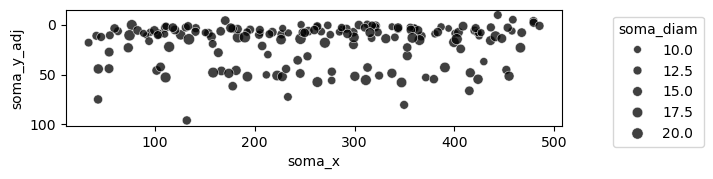

In [88]:
ctype = ['mg2','mg1','lg','lf']
mask_ids = df_type[df_type['cell_type'].isin(ctype)]['id'].values
hfig,ax = plt.subplots(1)
sns.scatterplot(data=df_soma[df_soma['id'].isin(mask_ids)],x = 'soma_x',y = 'soma_y_adj',
                ax = ax,
                size='soma_diam',sizes=(25,25*(20/7.5)),alpha=0.75,color='black')
# points = ax.scatter(x=x, y=y, **kws)
ax.set_aspect('equal')
ax.invert_yaxis()
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
# plt.savefig('/Users/kperks/Downloads/soma_positions.svg',transparent=True) 

In [88]:
df_soma['id'].values

array([102463116, 103366246, 103549879, ..., 669119245, 670337293,
        97780449])

In [81]:
# add cell type to df_soma
ctype = [df_type[df_type['id'].isin([cid])]['cell_type'].values[0] for cid in df_soma['id'].values]
df_soma['cell_type'] = ctype

In [82]:
ctype = ['grc','smpl','sg1','sg2','mg2','mg1','lg','lf'] #['sgx1','sgx2','mli','tsd','h']#
mask = df_soma['cell_type'].isin(ctype)

In [83]:
df_soma[mask][['soma_y_adj','cell_type']].groupby('cell_type').describe()

soma_y_adj                                                         \
               count       mean        std        min        25%        50%   
cell_type                                                                     
grc            528.0  74.340999  11.819518  49.915698  65.599304  71.948219   
lf              46.0  52.933449  10.547937  37.043947  46.575243  51.026202   
lg              42.0  19.334038   6.435384   8.997316  14.099991  18.700147   
mg1             67.0   4.831571   4.465751  -9.624030   2.618602   4.113343   
mg2             69.0   8.542698   5.470178  -4.012452   5.438705   7.848472   
sg1            400.0  16.714079   8.747503  -4.237026   9.868551  15.725627   
sg2            190.0  34.504254  18.837946   1.459296  16.986375  37.272737   
smpl           101.0  36.762788  10.489105  -0.209061  30.614774  36.638607   

                                  
                 75%         max  
cell_type                         
grc        81.153161  113.510302  
lf         54.683066   95.965668  
lg         23.193349   35.738522  
mg1         7.344081   19.326399  
mg2        11.207993   30.049837  
sg1        22.367902   42.988543  
sg2        50.923962   64.670721  
smpl       45.452538   58.179397

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_50876/3561232604.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['OFF','ON','MG-','MG+','SG-','SG+','SP-','Gr+'])


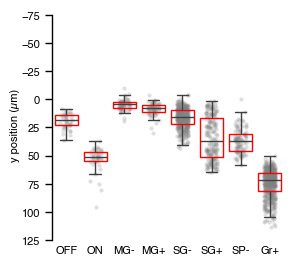

In [84]:
xorder = ['lg','lf','mg1','mg2','sg1','sg2','smpl','grc']
hfig,ax = plt.subplots(1,figsize=(3,3))
sns.boxplot(data=df_soma[mask],y='soma_y_adj',x='cell_type',legend=False,
            order = xorder,showfliers=False,
        ax=ax,**{'boxprops':{'facecolor':'none', 'edgecolor':'red'}},zorder=100)#,dodge=0.8)
sns.stripplot(ax = ax, data=df_soma[mask],x = 'cell_type',y='soma_y_adj',s=3,
            order = xorder,
              dodge=True,jitter=0.2,alpha=0.25,color='gray',legend=False)
ax.invert_yaxis()
ax.set_ylim(125,-80)
# ax.set_ylabel('number of target cells')
ax.set_ylabel('y position (µm)')
ax.set_xlabel('')
# ax.set_yticks([0,5,10])#,15])
ax.set_xticklabels(['OFF','ON','MG-','MG+','SG-','SG+','SP-','Gr+'])
ax.tick_params(axis='x', which='major', length=0)
sns.despine(bottom=True,trim=True)


plt.savefig('/Users/kperks/Downloads/soma_position.svg') 

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_50876/1177026058.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['OFF','ON','MG-','MG+','SG-','SG+','SP-','Gr+'])


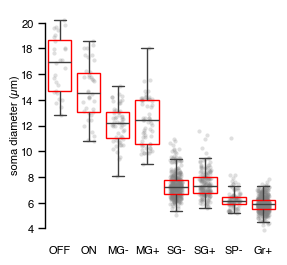

In [85]:
hfig,ax = plt.subplots(1,figsize=(3,3))
sns.boxplot(data=df_soma[mask],y='soma_diam',x='cell_type',legend=False,
            order = xorder,showfliers=False,
        ax=ax,**{'boxprops':{'facecolor':'none', 'edgecolor':'red'}},zorder=100)#,dodge=0.8)
sns.stripplot(ax = ax, data=df_soma[mask],x = 'cell_type',y='soma_diam',s=3,
            order = xorder,
              dodge=True,jitter=0.2,alpha=0.25,color='gray',legend=False)

# ax.set_ylabel('number of target cells')
ax.set_ylabel('soma diameter (µm)')
ax.set_xlabel('')
# ax.set_yticks([0,5,10])#,15])
ax.set_xticklabels(['OFF','ON','MG-','MG+','SG-','SG+','SP-','Gr+'])
ax.tick_params(axis='x', which='major', length=0)
sns.despine(bottom=True,trim=True)


plt.savefig('/Users/kperks/Downloads/soma_diameter.svg') 

In [ ]:
ctype = ['grc','smpl','sg1','sg2','mg2','mg1','lg','lf']
mask_ids = df_type[df_type['cell_type'].isin(ctype)]['id'].values

hfig = plt.figure(figsize=(1.5,2.5))
ax = plt.gca()
sns.kdeplot(data=df_soma[df_soma['id'].isin(mask_ids)],y='soma_y_adj',hue = 'cell_type',palette=cell_colors, fill=False,ax=ax,legend=False,cut=0, common_norm = False) # ,bins=20,element="poly",
ax.invert_yaxis()

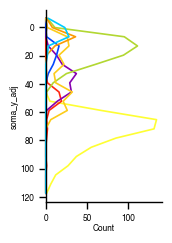

In [105]:
ctype = ['grc','smpl','sg1','sg2','mg2','mg1','lg','lf']
mask_ids = df_type[df_type['cell_type'].isin(ctype)]['id'].values

hfig = plt.figure(figsize=(1.5,2.5))
ax = plt.gca()
sns.histplot(data=df_soma[df_soma['id'].isin(mask_ids)],y='soma_y_adj',hue = 'cell_type',palette=cell_colors, fill=False,ax=ax,legend=False,clip_on=False, bins=20,element="poly")
ax.invert_yaxis()

In [ ]:
for c_ in ctype:
    c_ids = df_type[df_type['cell_type'].isin([c_])]['id'].values
    soma_pts = df_soma[df_soma['id'].isin(c_ids)][['soma_x','soma_y','soma_z']].values * 1000
    scale_factor = 100000
    
    yaxis_replace_scale = 0 #32768*16/scale_factor
    # zaxis_replace_scale = 3500*30/scale_factor
    refpt = [0,0,0]
    
    vertices = [[(v[0]-refpt[0])/scale_factor,
         (v[1]-refpt[1])/scale_factor,
         (v[2]-refpt[2])/scale_factor] for v in soma_pts]
    vertices = [[v[0],yaxis_replace_scale-v[1],-v[2]] for v in vertices] #in this case, the z needed to be mirrored (not sure why did not need to do for cells to blender)
    
    # fullpath = f'/Users/kperks/Library/CloudStorage/GoogleDrive-kperky@gmail.com/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Krista/blender/soma_locations/{c_}_soma.xyz'
    # with open(fullpath, 'w') as file:
    #     for v in vertices:
    
    #        # file.write(f'{s[0]},{s[1]},{s[2]}\n')
    #         file.write("{}\t {}\t {}\n".format(v[0],v[2],v[1]))

# Synapse locations (axon termination)

In [86]:
df_syn = pd.read_csv(dirpath.parent / 'data_processed_published/df_postsyn.csv')
syn = 'post-synaptic'

len(df_syn)

19584

In [87]:
y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = efish.func_planar_curve((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']#*-1    

## add cell type to df_syn

In [88]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

# df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
# df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

In [89]:
ctype = ['aff','grc','smpl','sg1','sg2','mg2','mg1']
mask = df_syn['pre_type'].isin(ctype)

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_50876/570514136.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['MG-','MG+','SG-','SG+','SP-','Gr+','EAF'])


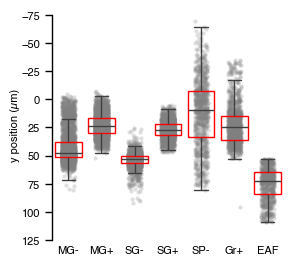

In [91]:
xorder = ['mg1','mg2','sg1','sg2','smpl','grc','aff']
hfig,ax = plt.subplots(1,figsize=(3,3))
sns.boxplot(data=df_syn[mask],y='y_adj',x='pre_type',legend=False,
            order = xorder,showfliers=False,
        ax=ax,**{'boxprops':{'facecolor':'none', 'edgecolor':'red'}},zorder=100)#,dodge=0.8)
sns.stripplot(ax = ax, data=df_syn[mask],x = 'pre_type',y='y_adj',s=3,
            order = xorder,
              dodge=True,jitter=0.2,alpha=0.25,color='gray',legend=False)
ax.invert_yaxis()
ax.set_ylim(125,-80)
# ax.set_ylabel('number of target cells')
ax.set_ylabel('y position (µm)')
ax.set_xlabel('')
# ax.set_yticks([0,5,10])#,15])
ax.set_xticklabels(['MG-','MG+','SG-','SG+','SP-','Gr+','EAF'])
ax.tick_params(axis='x', which='major', length=0)
sns.despine(bottom=True,trim=True)


plt.savefig('/Users/kperks/Downloads/postsynaptic_location.svg') 

# Create MG axon and basal dendrite mesh in colab

Use 'morphology_cat_createDF.ipynb'

old method in colab:
https://colab.research.google.com/drive/1wZ2v1ZFZ6fdlo_hJ9Hy_6w_6wOSe1NDe?usp=sharing

# Cell structures from nodes

In [31]:
csv_dir = dirpath.parent / 'data_processed_published/morphology_cat'

df_ax_list = []
for f in ['df_nodes_ax_type1.csv','df_nodes_ax_type2.csv']:
    df_ax_list.append(pd.read_csv(csv_dir / f))
df_ax = pd.concat(df_ax_list)
df_ax.set_index('id',inplace=True)
df_ax = df_ax.loc[:, ~df_ax.columns.str.contains('^Unnamed')]

df_bd_list = []
for f in ['df_nodes_bd_type1.csv','df_nodes_bd_type2.csv']:
    df_bd_list.append(pd.read_csv(csv_dir / f))
df_bd = pd.concat(df_bd_list)
df_bd.set_index('id',inplace=True)
df_bd = df_bd.loc[:, ~df_bd.columns.str.contains('^Unnamed')]

df_ad_list = []
for f in ['df_nodes_ad_type1.csv','df_nodes_ad_type2.csv']:
    df_ad_list.append(pd.read_csv(csv_dir / f))
df_ad = pd.concat(df_ad_list)
df_ad.set_index('id',inplace=True)
df_ad = df_ad.loc[:, ~df_ad.columns.str.contains('^Unnamed')]

In [32]:
df_ax.columns

Index(['ax_count_x', 'ax_mean_x', 'ax_std_x', 'ax_min_x', 'ax_25%_x',
       'ax_50%_x', 'ax_75%_x', 'ax_max_x', 'ax_count_y', 'ax_mean_y',
       'ax_std_y', 'ax_min_y', 'ax_25%_y', 'ax_50%_y', 'ax_75%_y', 'ax_max_y',
       'ax_count_z', 'ax_mean_z', 'ax_std_z', 'ax_min_z', 'ax_25%_z',
       'ax_50%_z', 'ax_75%_z', 'ax_max_z', 'ax_unique_x', 'ax_unique_y',
       'ax_unique_z'],
      dtype='object')

# Merge morphology stats with soma and cell type info

In [33]:
df_soma = efish.measure_soma(nodefiles)

# Compute y-adjusted values
coords = df_soma[['soma_x', 'soma_z']].values * 1000
yoffsets = np.array([efish.func_planar_curve((x, z), *popt) for x, z in coords])
df_soma['soma_y_adj'] = df_soma['soma_y'] - yoffsets / 1000

In [34]:
data_frames = [df_ax,df_bd,df_ad,df_type[df_type['id'].isin(df_ax.index)],df_soma[df_soma['id'].isin(df_ax.index)]] 

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['id'],
                                            how='outer'), data_frames)
df_merged = df_merged.loc[:, ~df_merged.columns.str.contains('^Unnamed')]


# df_merged = df_merged[df_merged['cell_type'].isin(['sg1','sg2','mg1','mg2'])]#.head() # should not need this because which cell types are included is determined by the .csv files in morphology_cat

In [35]:
df_merged.groupby(['cell_type']).count()

,id,ax_count_x,ax_mean_x,ax_std_x,ax_min_x,ax_25%_x,ax_50%_x,ax_75%_x,ax_max_x,ax_count_y,...,ad_75%_z,ad_max_z,ad_unique_x,ad_unique_y,ad_unique_z,soma_diam,soma_x,soma_y,soma_z,soma_y_adj
cell_type,,,,,,,,,,,,,,,,,,,,,
mg1,61,61,57,57,57,57,57,57,57,61,...,61,61,0,0,0,52,61,61,61,61
mg2,58,58,58,58,58,58,58,58,58,58,...,58,58,0,0,0,52,58,58,58,58
sg1,414,414,413,413,413,413,413,413,413,414,...,412,412,2,2,2,403,412,412,412,412
sg2,195,195,188,188,188,188,188,188,188,195,...,194,194,1,1,1,183,195,195,195,195


In [36]:
df_merged['id'].nunique()

728

In [37]:
df_type.groupby(['cell_type']).count()

,id
cell_type,
UK,1
aff,50
fov,1719
glia,111
grc,712
h,93
lf,46
lg,42
mg1,61


In [17]:
df_merged.head()

,id,ax_count_x,ax_mean_x,ax_std_x,ax_min_x,ax_25%_x,ax_50%_x,ax_75%_x,ax_max_x,ax_count_y,...,ad_max_z,ad_unique_x,ad_unique_y,ad_unique_z,cell_type,soma_diam,soma_x,soma_y,soma_z,soma_y_adj
0,126618353,4376.0,271538.206353,46301.814689,10058.0,238472.0,284560.0,300388.0,370160.0,4376.0,...,106020.0,NaN,NaN,NaN,mg1,10.77,312.74,251.40,20.50,-0.347642
1,127641472,817.0,251187.493268,10621.264807,15062.0,248944.0,251728.0,254912.0,264432.0,817.0,...,30360.0,NaN,NaN,NaN,sg1,6.71,249.65,256.70,22.24,4.423643
2,127838393,1235.0,343412.301215,5829.035007,332944.0,337400.0,344960.0,346944.0,355776.0,1235.0,...,34560.0,NaN,NaN,NaN,sg1,7.38,340.06,257.24,16.18,4.868100
3,127857293,651.0,337055.533026,6272.770830,321712.0,333120.0,337408.0,342168.0,350448.0,651.0,...,78510.0,NaN,NaN,NaN,sg1,7.03,346.79,261.34,27.87,7.127986
4,127870654,6309.0,356805.434776,39620.091742,231920.0,332128.0,368512.0,381024.0,430592.0,6309.0,...,106020.0,NaN,NaN,NaN,mg1,10.87,360.65,258.52,22.58,3.954276


# analyze multidimensional morphology space

In [38]:
df_morph = deepcopy(df_merged[['id',
                    'ax_std_x','ax_std_z',
                    'bd_std_x','bd_std_z',
                    'ad_count_y',#'ad_std_y','ad_std_x','ad_std_z',
                    'soma_diam',#'soma_y_adj',
                               'cell_type']]).set_index(['id'])

In [39]:
print(len(df_morph[df_morph.isna().any(axis=1)]))
df_morph[df_morph.isna().any(axis=1)]#: Returns a boolean Series indicating whether each row contains at least one NaN value. #[['soma_diam']]


46


,ax_std_x,ax_std_z,bd_std_x,bd_std_z,ad_count_y,soma_diam,cell_type
id,,,,,,,
213328285,21887.257077,15587.733032,12960.898288,6904.424073,8236.0,NaN,sg1
299405462,NaN,NaN,25893.184366,28626.928719,127825.0,13.09,mg1
303242001,9792.374408,14312.638094,4789.038728,4723.809316,3288.0,NaN,sg1
40508404,NaN,NaN,39576.874765,25320.053512,76506.0,NaN,mg1
41591506,NaN,NaN,26042.516494,24377.563431,96172.0,NaN,mg1
41748464,1072.478133,2021.845797,19951.258886,24108.182539,59234.0,NaN,mg1
42185060,19847.382359,17955.748528,NaN,NaN,13473.0,8.91,sg1
42644625,12357.866183,10248.455180,NaN,NaN,10871.0,9.46,sg1
43587455,5927.254757,2966.969759,18859.026906,18330.468255,3442.0,NaN,mg1


## create class column

In [40]:
df_morph.loc[df_morph['cell_type'].isin(['sg1','sg2']),'class'] = 'sg'
df_morph.loc[df_morph['cell_type'].isin(['mg1','mg2']),'class'] = 'mg'

In [41]:
# df_morph.loc[mask]['class'].value_counts()

## merge out-of-volume metadata

In [42]:
df = pd.read_csv(dirpath.parent / 'data_processed_published/MG_partial-cat.csv')
df_morph = pd.merge(df_morph, df, on='id', how='left')

In [43]:
df_morph.head()

,id,ax_std_x,ax_std_z,bd_std_x,bd_std_z,ad_count_y,soma_diam,cell_type,class,ax,bd,type,ov
0,126618353,46301.814689,11417.035630,26885.253741,26697.389020,117768.0,10.77,mg1,mg,NaN,NaN,NaN,NaN
1,127641472,10621.264807,7389.254007,5969.375905,5803.358732,4338.0,6.71,sg1,sg,NaN,NaN,NaN,NaN
2,127838393,5829.035007,10449.575972,6605.987432,3608.284951,3809.0,7.38,sg1,sg,NaN,NaN,NaN,NaN
3,127857293,6272.770830,9299.522890,3872.944337,4290.338705,6057.0,7.03,sg1,sg,NaN,NaN,NaN,NaN
4,127870654,39620.091742,24061.081161,27302.194346,23264.437656,91307.0,10.87,mg1,mg,NaN,NaN,NaN,NaN


## visualize 2D morphology space

In [32]:
# Only include cells without any processes significantly out of the volume
mask = df_morph['ov'].isin([np.NaN]) 

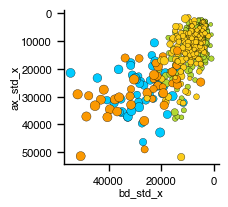

In [33]:
plt.figure(figsize=(2,2))
ax=sns.scatterplot(data=df_morph[mask], x='bd_std_x', y='ax_std_x', hue='cell_type',
                   size='soma_diam',sizes=(2,50),palette=cell_colors,edgecolors='black',legend=False)
#,size='soma_diam',sizes = (5,100
ax.invert_xaxis()
ax.invert_yaxis()
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)

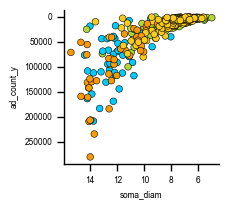

In [36]:
plt.figure(figsize=(2,2))
ax=sns.scatterplot(data=df_morph[mask], x='soma_diam', y='ad_count_y', hue='cell_type',
                   palette=cell_colors,edgecolors='black',legend=False) #,size='soma_diam',sizes=(5,100)
#,size='soma_diam',sizes = (5,100
ax.invert_xaxis()
ax.invert_yaxis()
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)

## Hierachical clustering

In [66]:
df_morph[mask]

,id,ax_std_x,ax_std_z,bd_std_x,bd_std_z,ad_count_y,soma_diam,cell_type,class,ax,bd,type,ov
0,126618353,46301.814689,11417.035630,26885.253741,26697.389020,117768.0,10.77,mg1,mg,NaN,NaN,NaN,NaN
1,127641472,10621.264807,7389.254007,5969.375905,5803.358732,4338.0,6.71,sg1,sg,NaN,NaN,NaN,NaN
2,127838393,5829.035007,10449.575972,6605.987432,3608.284951,3809.0,7.38,sg1,sg,NaN,NaN,NaN,NaN
3,127857293,6272.770830,9299.522890,3872.944337,4290.338705,6057.0,7.03,sg1,sg,NaN,NaN,NaN,NaN
4,127870654,39620.091742,24061.081161,27302.194346,23264.437656,91307.0,10.87,mg1,mg,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,395878224,23179.600187,22400.074216,14661.018858,25704.074068,2775.0,6.76,sg2,sg,NaN,NaN,NaN,NaN
724,137029520,8163.655896,9349.497867,5718.806629,2540.545541,3563.0,5.91,sg2,sg,NaN,NaN,NaN,NaN
725,135825400,7196.927873,11854.271791,9196.385856,6701.119783,6025.0,7.10,sg2,sg,NaN,NaN,NaN,NaN
726,50135965,9089.201530,13691.427134,8367.963037,5929.105930,4986.0,7.30,sg2,sg,NaN,NaN,NaN,NaN


In [44]:
mask = df_morph['ov'].isin([np.NaN])
features = ['id','soma_diam','bd_std_x', 'ax_std_x', 'ax_std_z','bd_std_z','ad_count_y']#,'ad_std_y']#,'ad_std_x','ad_std_z']# ,'soma_y_adj'

df_cluster = df_morph.loc[mask,features].set_index('id')#df_morph.loc[mask,features]
df_cluster.dropna(axis=0,inplace=True) # remove any cells from analysis that have NaN for any of the features

# standardize within each feature (Each column of dataframe)
df_cluster = df_cluster.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

In [45]:
df_cluster#.head()#.to_numpy(dtype='float32')

,soma_diam,bd_std_x,ax_std_x,ax_std_z,bd_std_z,ad_count_y
id,,,,,,
126618353,1.318809,1.966847,3.859893,-0.118810,2.590684,2.692783
127641472,-0.676995,-0.494484,-0.290099,-0.718506,-0.581549,-0.406561
127838393,-0.347638,-0.419569,-0.847482,-0.262855,-0.914816,-0.421015
127857293,-0.519690,-0.741187,-0.795871,-0.434086,-0.811263,-0.359591
127870654,1.367967,2.015911,3.082744,1.763762,2.069476,1.969766
...,...,...,...,...,...,...
395878224,-0.652416,0.528328,1.170556,1.516455,2.439874,-0.449268
137029520,-1.070257,-0.523970,-0.575943,-0.426645,-1.076925,-0.427737
135825400,-0.485280,-0.114737,-0.688383,-0.053710,-0.445247,-0.360466


In [46]:
Z = hierarchy.linkage(df_cluster, method='ward', metric='euclidean',optimal_ordering=True) #

### visualize clustering

In [47]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        # plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             fontsize=6,
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata


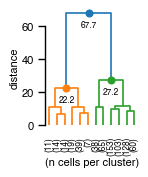

In [51]:
max_d = 40
plt.figure(figsize=(1.2,1.5))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=6.,
    show_contracted=True,
    annotate_above=15,
    # max_d=max_d,
    # ax = ax# plot a horizontal cut-off line
)
ax=plt.gca()
ax.set_ylim(0,70)
ax.set_xlabel('(n cells per cluster)')

sns.despine(bottom=True,trim=True)
plt.savefig('/Users/kperks/Downloads/mg_sg_dendrogram.svg') 

### categorize class based on clustering

In [52]:
max_d = 40
df_cluster['label'] = hierarchy.fcluster(Z, max_d, criterion='distance')

df_cluster.reset_index(inplace=True)

df_cluster = pd.merge(df_cluster,df_morph[['id','class']],on='id')

In [53]:
# how many of each class are in each cluster (label)?
df_cluster.groupby(['label','class'])['id'].count()

label  class
1      mg        87
       sg        17
2      sg       547
Name: id, dtype: int64

In [54]:
df_cluster[(df_cluster['label']==1) & (df_cluster['class']=='sg')]['id'].values

array([213501262, 387197529,  41579854,  41843700, 558346897, 559551706,
       127607174, 127672247, 300226567, 302003735, 302544942, 303166992,
       387382792, 472051969, 472361842, 475781099, 558934217])

In [55]:
df_cluster[(df_cluster['label']==2) & (df_cluster['class']=='mg')]['id'].values

array([], dtype=int64)

### adjust df_type and re-save as df_type_auto

In [56]:
for c in df_cluster[(df_cluster['label']==1) & (df_cluster['class']=='sg')]['id'].values:
    if df_type.loc[df_type[df_type['id'].isin([c])].index,'cell_type'].values[0] == 'sg1':
        df_type.loc[df_type[df_type['id'].isin([c])].index,'cell_type'] = 'mg1' 
    if df_type.loc[df_type[df_type['id'].isin([c])].index,'cell_type'].values[0] == 'sg2':
        df_type.loc[df_type[df_type['id'].isin([c])].index,'cell_type'] = 'mg2' 

In [57]:
for c in df_cluster[(df_cluster['label']==2) & (df_cluster['class']=='mg')]['id'].values:
    if df_type.loc[df_type[df_type['id'].isin([c])].index,'cell_type'].values[0] == 'mg1':
        df_type.loc[df_type[df_type['id'].isin([c])].index,'cell_type'] = 'sg1' 
    if df_type.loc[df_type[df_type['id'].isin([c])].index,'cell_type'].values[0] == 'mg2':
        df_type.loc[df_type[df_type['id'].isin([c])].index,'cell_type'] = 'sg2' 

In [58]:
dirpath

PosixPath('/Users/kperks/Documents/sawtell_lab/EM_data/reconstructions_published')

In [59]:
df_type.to_csv(dirpath.parent / 'data_processed_published/df_type_auto.csv')

### Quality

In [36]:
from scipy.spatial.distance import pdist, squareform

In [37]:
max_d = 40
clusters = hierarchy.fcluster(Z, max_d, criterion='distance')

In [ ]:

# Quality1 = metrics.silhouette_score(X=distArray, labels=clusters) # silhouette score
Quality2 = metrics.calinski_harabasz_score(X=df_cluster, labels=clusters) # calinski-harabasz score

In [406]:
Quality2

852.2679439659921

## PCA

In [60]:
'''
use same mask and features as just used for clustering (ie. don't change them)
'''
mask = df_morph['ov'].isin([np.NaN])
features = ['id','soma_diam','bd_std_x', 'ax_std_x', 'ax_std_z','bd_std_z','ad_count_y']#,'ad_std_y']#,'ad_std_x','ad_std_z']# ,'soma_y_adj'

df_pca = df_morph.loc[mask,features].set_index('id')
df_pca.dropna(axis=0,inplace=True)

In [344]:
df_pca

,soma_diam,bd_std_x,ax_std_x,ax_std_z,bd_std_z,ad_count_y
id,,,,,,
126618353,10.77,26885.253741,46301.814689,11417.035630,26697.389020,117768.0
127641472,6.71,5969.375905,10621.264807,7389.254007,5803.358732,4338.0
127838393,7.38,6605.987432,5829.035007,10449.575972,3608.284951,3809.0
127857293,7.03,3872.944337,6272.770830,9299.522890,4290.338705,6057.0
127870654,10.87,27302.194346,39620.091742,24061.081161,23264.437656,91307.0
...,...,...,...,...,...,...
395878224,6.76,14661.018858,23179.600187,22400.074216,25704.074068,2775.0
137029520,5.91,5718.806629,8163.655896,9349.497867,2540.545541,3563.0
135825400,7.10,9196.385856,7196.927873,11854.271791,6701.119783,6025.0


In [61]:
# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)#.drop(columns=['id','cell_type']))

pca = PCA(n_components=len(df_pca.columns))  # You can adjust the number of components as needed
pca_result = pca.fit_transform(df_scaled)
# get loadings of dimensions onto each principal component
loadings = pca.components_.T

# Convert PCA result to DataFrame
df_pca_result = pd.DataFrame(pca_result)#, columns=['PC1', 'PC2', 'PC3','PC4','PC5'])

In [62]:
df_pca_result['id'] = list(df_pca.index)
df_pca_result.set_index('id',inplace=True)

In [63]:
df_final = df_pca.reset_index().merge(df_pca_result.reset_index(),on='id').merge(df_morph[['id','cell_type','class']],on='id')

In [64]:
df_final

,id,soma_diam,bd_std_x,ax_std_x,ax_std_z,bd_std_z,ad_count_y,0,1,2,3,4,5,cell_type,class
0,126618353,10.77,26885.253741,46301.814689,11417.035630,26697.389020,117768.0,5.038707,0.673492,2.676810,-0.816973,0.452521,0.810377,mg1,mg
1,127641472,6.71,5969.375905,10621.264807,7389.254007,5803.358732,4338.0,-1.296249,0.100248,0.332345,-0.030805,-0.046863,0.074875,sg1,sg
2,127838393,7.38,6605.987432,5829.035007,10449.575972,3608.284951,3809.0,-1.314582,0.122143,-0.338727,0.399805,-0.183096,-0.224565,sg1,sg
3,127857293,7.03,3872.944337,6272.770830,9299.522890,4290.338705,6057.0,-1.502082,0.138289,-0.204389,0.333315,0.059129,0.026909,sg1,sg
4,127870654,10.87,27302.194346,39620.091742,24061.081161,23264.437656,91307.0,4.985178,-0.584338,1.128476,-0.087803,-0.139180,0.509141,mg1,mg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,395878224,6.76,14661.018858,23179.600187,22400.074216,25704.074068,2775.0,1.834533,-1.722762,-0.255749,-1.642551,-0.146261,1.194758,sg2,sg
647,137029520,5.91,5718.806629,8163.655896,9349.497867,2540.545541,3563.0,-1.696118,-0.063139,0.131554,0.382336,-0.435507,0.218040,sg2,sg
648,135825400,7.10,9196.385856,7196.927873,11854.271791,6701.119783,6025.0,-0.879090,-0.002051,-0.376588,0.076008,-0.366529,0.021815,sg2,sg
649,50135965,7.30,8367.963037,9089.201530,13691.427134,5929.105930,4986.0,-0.748785,-0.288692,-0.337845,0.294278,-0.292085,-0.036399,sg2,sg


In [349]:
morpho_savepath = Path(dirpath).parent / 'meta_analysis/morphology_cat/'

In [350]:
# 
# df_final.to_csv(morpho_savepath / 'df_morphology_cat_pca.csv')

In [29]:
df_final = pd.read_csv(morpho_savepath / 'df_morphology_cat_pca.csv')

,Unnamed: 0,index,id,cell_type,soma_diam,bd_std_x,ax_std_x,ax_std_z,bd_std_z,ad_count_y,0,1,2,3,4,5
0,0,0,126618353,mg1,10.77,26885.253741,46301.814689,11417.035630,26697.389020,117768.0,5.032050,0.671628,2.680766,-0.770118,0.390457,0.869899
1,1,1,127641472,sg1,6.71,5969.375905,10621.264807,7389.254007,5803.358732,4338.0,-1.297123,0.095290,0.331514,-0.020076,-0.053213,0.072753
2,2,2,127838393,sg1,7.38,6605.987432,5829.035007,10449.575972,3608.284951,3809.0,-1.315943,0.114890,-0.341220,0.398791,-0.158557,-0.246932
3,3,3,127857293,sg1,7.03,3872.944337,6272.770830,9299.522890,4290.338705,6057.0,-1.502470,0.131475,-0.207686,0.332131,0.068136,0.017751
4,4,4,127870654,mg1,10.87,27302.194346,39620.091742,24061.081161,23264.437656,91307.0,4.976324,-0.581985,1.124731,-0.056950,-0.169986,0.523843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,640,716,648567066,sg2,6.69,6365.607242,6130.954404,5294.870307,5048.345271,6439.0,-1.629646,0.557925,0.105999,-0.047091,-0.134256,0.003687
641,641,718,649572893,sg2,7.34,5188.262037,12009.573951,7293.262322,8897.625302,6971.0,-0.917962,0.119411,0.314964,-0.288567,0.319666,0.112829
642,642,719,649805291,sg2,5.75,4190.174815,3072.631629,2089.188893,6183.927626,2986.0,-2.220749,0.815615,0.099599,-0.412259,-0.104562,0.349588
643,643,720,650501012,sg2,9.45,14423.530035,4813.959331,3337.084594,13565.063377,444.0,-0.334266,1.203875,-0.369688,-1.255465,0.146201,-0.823140


<AxesSubplot:xlabel='0'>

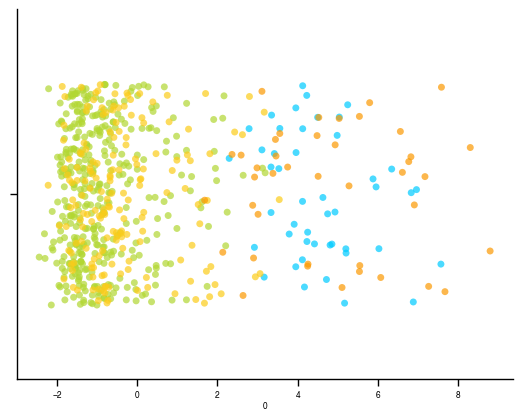

In [351]:
sns.stripplot(data=df_final,x=0,hue='cell_type',jitter = 0.3,alpha = 0.7,palette=cell_colors,legend=False)
# mask = df_final['id'].isin(df_edges['pre'])
# sns.stripplot(data=df_final[mask],x=0,color='black',s=8,jitter = 0.1)
# mask = df_final['id'].isin([309774327,394329802])
# sns.stripplot(data=df_final[mask],x=0,color='gray',s=8)
# sns.scatterplot(data=df_final,x=0,y=1,hue='cell_type')

In [352]:
df_final = df_final.merge(df_soma,on='id')

In [50]:
df_final

,id,soma_diam_x,bd_std_x,ax_std_x,ax_std_z,bd_std_z,ad_count_y,0,1,2,3,4,5,cell_type,class,soma_diam_y,soma_x,soma_y,soma_z,soma_y_adj
0,126618353,10.77,26885.253741,46301.814689,11417.035630,26697.389020,117768.0,5.038707,0.673492,2.676810,-0.816973,0.452521,0.810377,mg1,mg,10.77,312.74,251.40,20.50,-0.347642
1,127641472,6.71,5969.375905,10621.264807,7389.254007,5803.358732,4338.0,-1.296249,0.100248,0.332345,-0.030805,-0.046863,0.074875,sg1,sg,6.71,249.65,256.70,22.24,4.423643
2,127838393,7.38,6605.987432,5829.035007,10449.575972,3608.284951,3809.0,-1.314582,0.122143,-0.338727,0.399805,-0.183096,-0.224565,sg1,sg,7.38,340.06,257.24,16.18,4.868100
3,127857293,7.03,3872.944337,6272.770830,9299.522890,4290.338705,6057.0,-1.502082,0.138289,-0.204389,0.333315,0.059129,0.026909,sg1,sg,7.03,346.79,261.34,27.87,7.127986
4,127870654,10.87,27302.194346,39620.091742,24061.081161,23264.437656,91307.0,4.985178,-0.584338,1.128476,-0.087803,-0.139180,0.509141,mg1,mg,10.87,360.65,258.52,22.58,3.954276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,395878224,6.76,14661.018858,23179.600187,22400.074216,25704.074068,2775.0,1.834533,-1.722762,-0.255749,-1.642551,-0.146261,1.194758,sg2,sg,6.76,385.54,317.78,59.40,54.073388
647,137029520,5.91,5718.806629,8163.655896,9349.497867,2540.545541,3563.0,-1.696118,-0.063139,0.131554,0.382336,-0.435507,0.218040,sg2,sg,5.91,354.00,311.07,16.98,57.730893
648,135825400,7.10,9196.385856,7196.927873,11854.271791,6701.119783,6025.0,-0.879090,-0.002051,-0.376588,0.076008,-0.366529,0.021815,sg2,sg,7.10,329.82,309.75,27.38,56.610088
649,50135965,7.30,8367.963037,9089.201530,13691.427134,5929.105930,4986.0,-0.748785,-0.288692,-0.337845,0.294278,-0.292085,-0.036399,sg2,sg,7.30,411.47,307.12,10.42,48.141267


In [43]:
df_final[df_final['cell_type'].isin(['mg1'])][['id','soma_diam_x','soma_x','soma_z',0]].sort_values(0)

,id,soma_diam_x,soma_x,soma_z,0
120,299392199,10.75,248.50,56.49,2.287834
78,215480645,11.20,110.56,39.16,2.784975
126,300131090,13.10,67.00,45.92,2.914681
309,472409584,12.13,310.25,83.04,3.100893
311,472994717,11.93,55.01,72.68,3.159989
404,560744270,14.26,390.97,89.24,3.328349
60,214550811,9.42,205.82,36.39,3.329831
369,557092670,11.12,287.14,89.49,3.339009
76,215030183,12.50,415.25,28.16,3.415521
209,386643184,10.45,355.85,65.92,3.523717


In [ ]:
'386224676', '299405462', '299439953', '299496636'

In [358]:
df_final

,id,soma_diam_x,bd_std_x,ax_std_x,ax_std_z,bd_std_z,ad_count_y,0,1,2,3,4,5,cell_type,class,soma_diam_y,soma_x,soma_y,soma_z,soma_y_adj
0,126618353,10.77,26885.253741,46301.814689,11417.035630,26697.389020,117768.0,5.038707,0.673492,2.676810,-0.816973,0.452521,0.810377,mg1,mg,10.77,312.74,251.40,20.50,-0.347642
1,127641472,6.71,5969.375905,10621.264807,7389.254007,5803.358732,4338.0,-1.296249,0.100248,0.332345,-0.030805,-0.046863,0.074875,sg1,sg,6.71,249.65,256.70,22.24,4.423643
2,127838393,7.38,6605.987432,5829.035007,10449.575972,3608.284951,3809.0,-1.314582,0.122143,-0.338727,0.399805,-0.183096,-0.224565,sg1,sg,7.38,340.06,257.24,16.18,4.868100
3,127857293,7.03,3872.944337,6272.770830,9299.522890,4290.338705,6057.0,-1.502082,0.138289,-0.204389,0.333315,0.059129,0.026909,sg1,sg,7.03,346.79,261.34,27.87,7.127986
4,127870654,10.87,27302.194346,39620.091742,24061.081161,23264.437656,91307.0,4.985178,-0.584338,1.128476,-0.087803,-0.139180,0.509141,mg1,mg,10.87,360.65,258.52,22.58,3.954276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,395878224,6.76,14661.018858,23179.600187,22400.074216,25704.074068,2775.0,1.834533,-1.722762,-0.255749,-1.642551,-0.146261,1.194758,sg2,sg,6.76,385.54,317.78,59.40,54.073388
647,137029520,5.91,5718.806629,8163.655896,9349.497867,2540.545541,3563.0,-1.696118,-0.063139,0.131554,0.382336,-0.435507,0.218040,sg2,sg,5.91,354.00,311.07,16.98,57.730893
648,135825400,7.10,9196.385856,7196.927873,11854.271791,6701.119783,6025.0,-0.879090,-0.002051,-0.376588,0.076008,-0.366529,0.021815,sg2,sg,7.10,329.82,309.75,27.38,56.610088
649,50135965,7.30,8367.963037,9089.201530,13691.427134,5929.105930,4986.0,-0.748785,-0.288692,-0.337845,0.294278,-0.292085,-0.036399,sg2,sg,7.30,411.47,307.12,10.42,48.141267


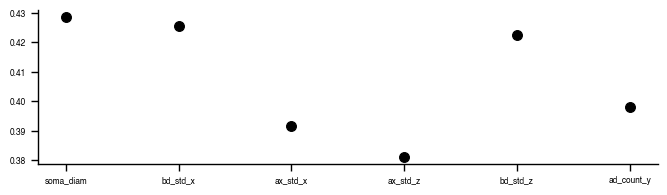

In [363]:
hfig,ax = plt.subplots(figsize = (8,2))
ax.scatter(df_pca.columns,[l[0] for l in loadings],color = 'black',s=50)

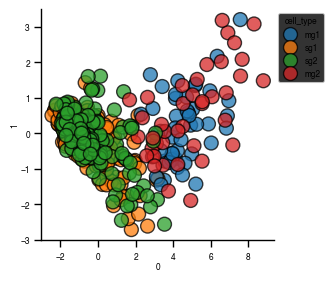

In [364]:
hfig,ax = plt.subplots(1,figsize=(3,3))
sns.scatterplot(ax=ax,data=df_final,hue='cell_type',x=0,y=1,linewidth=1,edgecolor='black',s=100,alpha = 0.75)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<AxesSubplot:xlabel='0', ylabel='Count'>

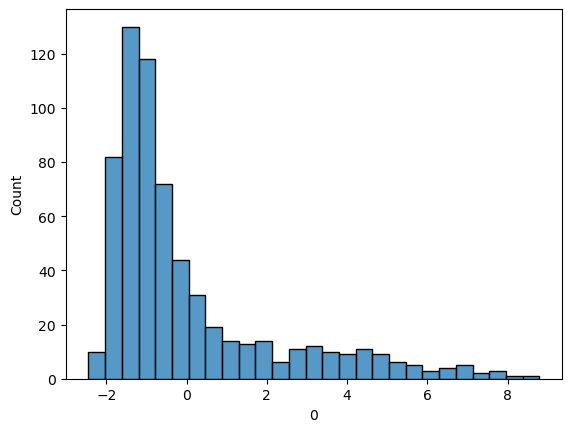

In [472]:
sns.histplot(data=df_final,x=0)#,cut=0,clip_on=0)#,jitter = 0.3,alpha = 0.4)

<AxesSubplot:xlabel='0', ylabel='Density'>

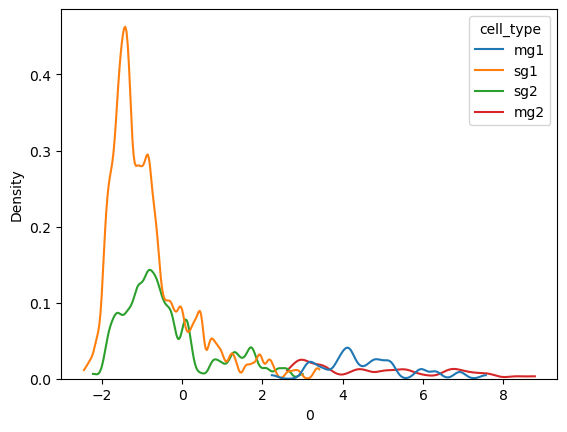

In [474]:
sns.kdeplot(data=df_final,x=0,hue='cell_type',cut=0,clip_on=0,bw_adjust=0.25)#,jitter = 0.3,alpha = 0.4)

# Type 1 vs Type 2

In [47]:
df_merged.head()

,id,ax_count_x,ax_mean_x,ax_std_x,ax_min_x,ax_25%_x,ax_50%_x,ax_75%_x,ax_max_x,ax_count_y,...,ad_max_z,ad_unique_x,ad_unique_y,ad_unique_z,cell_type,soma_diam,soma_x,soma_y,soma_z,soma_y_adj
0,126618353,4376.0,271538.206353,46301.814689,10058.0,238472.0,284560.0,300388.0,370160.0,4376.0,...,106020.0,NaN,NaN,NaN,mg1,10.77,312.74,251.40,20.50,-0.347642
1,127641472,817.0,251187.493268,10621.264807,15062.0,248944.0,251728.0,254912.0,264432.0,817.0,...,30360.0,NaN,NaN,NaN,sg1,6.71,249.65,256.70,22.24,4.423643
2,127838393,1235.0,343412.301215,5829.035007,332944.0,337400.0,344960.0,346944.0,355776.0,1235.0,...,34560.0,NaN,NaN,NaN,sg1,7.38,340.06,257.24,16.18,4.868100
3,127857293,651.0,337055.533026,6272.770830,321712.0,333120.0,337408.0,342168.0,350448.0,651.0,...,78510.0,NaN,NaN,NaN,sg1,7.03,346.79,261.34,27.87,7.127986
4,127870654,6309.0,356805.434776,39620.091742,231920.0,332128.0,368512.0,381024.0,430592.0,6309.0,...,106020.0,NaN,NaN,NaN,mg1,10.87,360.65,258.52,22.58,3.954276


In [65]:
df_morph = deepcopy(df_merged[['id',
                    'ax_50%_y','bd_50%_y',
                    'bd_std_y','ax_min_y','ax_max_y',
                    'ax_count_y','bd_count_y',
                    'soma_diam','soma_y_adj',
                               'cell_type']]).set_index(['id'])

for col in ['ax_50%_y','bd_50%_y','soma_y_adj']:
    df_morph[col] = df_morph[col]/1000 * -1
for col in ['soma_diam']:
    df_morph[col] = df_morph[col]/1000 

df = pd.read_csv(dirpath.parent / 'data_processed_published/MG_partial-cat.csv')
df_morph = pd.merge(df_morph, df, on='id', how='left')
# df_morph.fillna(False, inplace=True)

df_morph.fillna(False, inplace=True)

## mg

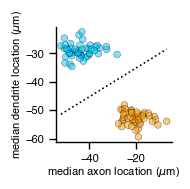

In [76]:
mask = (df_morph['ov'].isin([False])) & (df_morph['cell_type'].isin(['mg1','mg2']))

X=df_morph[mask][['ax_50%_y','bd_50%_y']]
y=df_morph[mask]['cell_type']

lr = LogisticRegression()
lr.fit(X,y)

# mask = (df_morph['cell_type'].isin(['mg1','mg2']))

fig, ax = plt.subplots(figsize=(1.5,1.5))

sns.scatterplot(ax=ax,data=df_morph[mask],x='ax_50%_y',y='bd_50%_y',hue='cell_type',
                palette=cell_colors, alpha = 0.5,edgecolor='black',
               legend=False)

# Get the current axis limits
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x = np.linspace(min(df_morph[mask]['ax_50%_y']), max(df_morph[mask]['ax_50%_y']), 100)
y = (-lr.intercept_ - lr.coef_[0][0]*x) / lr.coef_[0][1]
plt.plot(x,y,color='black',linestyle='dotted')


ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)

# h, l = ax.get_legend_handles_labels()
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)

# Set the font size for the axis labels
ax.set_xlabel('median axon location ($\\mu$m)')
ax.set_ylabel('median dendrite location ($\\mu$m)')


# plt.savefig('mg_cat_ax-bd-dist_full-cells-classifier.svg', format='svg', dpi=fig_dpi)
plt.savefig('/Users/kperks/Downloads/CellType_mg_ax-bd_linear-classifier.svg',transparent=True) 

In [77]:
df_result = deepcopy(df_morph[mask])

In [78]:
df_result.loc[:,'label'] = lr.predict(X)

In [79]:
df_result.groupby(['cell_type','label']).count()

,,id,ax_50%_y,bd_50%_y,bd_std_y,ax_min_y,ax_max_y,ax_count_y,bd_count_y,soma_diam,soma_y_adj,ax,bd,type,ov
cell_type,label,,,,,,,,,,,,,,
mg1,mg1,49,49,49,49,49,49,49,49,49,49,49,49,49,49
mg2,mg2,44,44,44,44,44,44,44,44,44,44,44,44,44,44


## sg

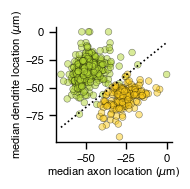

In [67]:
mask = (df_morph['ov'].isin([False])) & (df_morph['cell_type'].isin(['sg1','sg2']))

X=df_morph[mask][['ax_50%_y','bd_50%_y']]
y=df_morph[mask]['cell_type']

lr = LogisticRegression()
lr.fit(X,y)

# mask = (df_morph['cell_type'].isin(['mg1','mg2']))

fig, ax = plt.subplots(figsize=(1.5,1.5))

sns.scatterplot(ax=ax,data=df_morph[mask],x='ax_50%_y',y='bd_50%_y',hue='cell_type',
                palette=cell_colors, alpha = 0.5,edgecolor='black',
               legend=False)
# sns.scatterplot(ax=ax,data=df_morph[mask & ((df_morph['ax_count_y']<500) | (df_morph['bd_count_y']<500))],
#                 x='ax_50%_y',y='bd_50%_y',hue='cell_type',palette=cell_colors, alpha = 1,edgecolor='red',linewidth=1.5)

# Get the current axis limits
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x = np.linspace(min(df_morph[mask]['ax_50%_y']), max(df_morph[mask]['ax_50%_y']), 100)
y = (-lr.intercept_ - lr.coef_[0][0]*x) / lr.coef_[0][1]
plt.plot(x,y,color='black',linestyle='dotted')


ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)

# h, l = ax.get_legend_handles_labels()
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)

# ax.plot([x_min, x_max], [y_min, y_max], linestyle='dotted', color='black')
# ax.set_xticks(np.arange(min_value, max_value + step, step))
# ax.set_xticks(ax.get_xticks())
# ax.set_yticks(ax.get_yticks())
# ax.set_xticklabels([str(int(float(t))) for t in ax.get_xticks()])
# ax.set_yticklabels([str(int(float(t))) for t in ax.get_yticks()])

# Set the font size for the tick labels
# ax.tick_params(labelsize=14)

# Set the font size for the axis labels
ax.set_xlabel('median axon location ($\\mu$m)')
ax.set_ylabel('median dendrite location ($\\mu$m)')


# plt.savefig('mg_cat_ax-bd-dist_full-cells-classifier.svg', format='svg', dpi=fig_dpi)
plt.savefig('/Users/kperks/Downloads/CellType_sg_ax-bd_linear-classifier.svg',transparent=True) 

In [68]:
df_result = deepcopy(df_morph[mask])

In [69]:
df_result.loc[:,'label'] = lr.predict(X)

In [70]:
df_result.groupby(['cell_type','label']).count()

id  ax_50%_y  bd_50%_y  bd_std_y  ax_min_y  ax_max_y  \
cell_type label                                                          
sg1       sg1    398       398       398       398       398       398   
          sg2      6         6         6         6         6         6   
sg2       sg2    179       179       179       179       179       179   

                 ax_count_y  bd_count_y  soma_diam  soma_y_adj   ax   bd  \
cell_type label                                                            
sg1       sg1           398         398        398         398  398  398   
          sg2             6           6          6           6    6    6   
sg2       sg2           179         179        179         179  179  179   

                 type   ov  
cell_type label             
sg1       sg1     398  398  
          sg2       6    6  
sg2       sg2     179  179

In [71]:
df_result[df_result['cell_type'].isin(['sg1']) & df_result['label'].isin(['sg2']) ]['id'].values

array([128751464, 215897023, 389658102, 393450060,  44180995, 645287544])

### adjust df_type and re-save as df_type_auto

In [72]:
for c in df_result[(df_result['label']=='sg2') & (df_result['cell_type']=='sg1')]['id'].values:
    df_type.loc[df_type[df_type['id'].isin([c])].index,'cell_type'] = 'sg2' 
    

In [73]:
for c in df_result[(df_result['label']=='sg1') & (df_result['cell_type']=='sg2')]['id'].values:
    df_type.loc[df_type[df_type['id'].isin([c])].index,'cell_type'] = 'sg1' 

In [74]:
dirpath

PosixPath('/Users/kperks/Documents/sawtell_lab/EM_data/reconstructions_published')

In [75]:
df_type.to_csv(dirpath.parent / 'data_processed_published/df_type_auto_typed.csv')

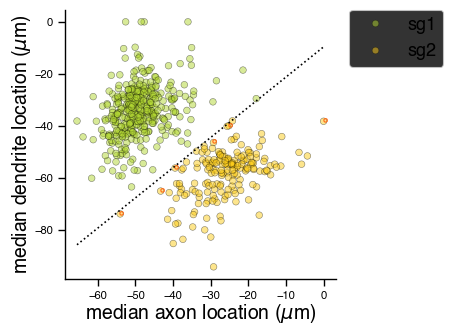

In [61]:


fig, ax = plt.subplots(figsize=(3.5,3.5))

mask = (df_result['ov'].isin([False])) & (df_result['cell_type'].isin(['sg1','sg2']))
sns.scatterplot(ax=ax,data=df_result[mask],x='ax_50%_y',y='bd_50%_y',hue='label',palette=cell_colors, alpha = 0.5,edgecolor='black')
mask_elim = (df_result['ov'].isin([False])) & (df_result['cell_type'].isin(['sg1','sg2'])) & (df_result['cell_type'].isin(['sg1']) & df_result['label'].isin(['sg2'])) 
sns.scatterplot(ax=ax,data=df_result[mask_elim],x='ax_50%_y',y='bd_50%_y',marker="$\circ$", facecolor = None,alpha=1,edgecolor='red',linewidth=0.1)

# Get the current axis limits
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x = np.linspace(min(df_result[mask]['ax_50%_y']), max(df_result[mask]['ax_50%_y']), 100)
y = (-lr.intercept_ - lr.coef_[0][0]*x) / lr.coef_[0][1]
plt.plot(x,y,color='black',linestyle='dotted')


ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)

h, l = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)

# ax.plot([x_min, x_max], [y_min, y_max], linestyle='dotted', color='black')
# ax.set_xticks(np.arange(min_value, max_value + step, step))
# ax.set_xticks(ax.get_xticks())
# ax.set_yticks(ax.get_yticks())
# ax.set_xticklabels([str(int(float(t))) for t in ax.get_xticks()])
# ax.set_yticklabels([str(int(float(t))) for t in ax.get_yticks()])

# Set the font size for the tick labels
# ax.tick_params(labelsize=14)

# Set the font size for the axis labels
ax.set_xlabel('median axon location ($\\mu$m)', fontsize=14)
ax.set_ylabel('median dendrite location ($\\mu$m)', fontsize=14)


# plt.savefig('mg_cat_ax-bd-dist_full-cells-classifier.svg', format='svg', dpi=fig_dpi)
plt.savefig('/Users/kperks/Downloads/sg_cat_ax-bd-dist_full-cells-classifier_RESULT.svg',transparent=True) 

### TODO: check cells with low ax or bd counts for ov and document on MG_partial-cat csv

(0.0, 2000.0)

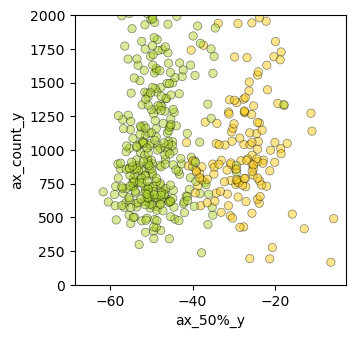

In [369]:
mask = (df_morph['ov'].isin([False])) & (df_morph['cell_type'].isin(['sg1','sg2']))

fig, ax = plt.subplots(figsize=(3.5,3.5))
sns.scatterplot(ax=ax,data=df_morph[mask],x='ax_50%_y',y='ax_count_y',hue='cell_type',palette=cell_colors, alpha = 0.5,edgecolor='black',legend=False)
ax.set_ylim(0,2000)

# mask = ((df_pca_prep['bdcount_x'] < 2000) | (df_pca_prep['axcount_x'] < 2000))

(0.0, 2000.0)

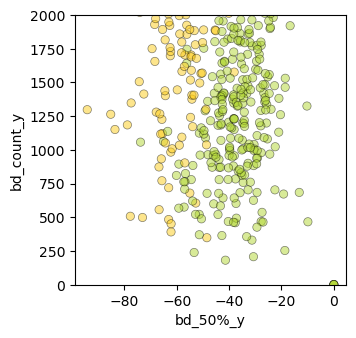

In [368]:
mask = (df_morph['ov'].isin([False])) & (df_morph['cell_type'].isin(['sg1','sg2']))

fig, ax = plt.subplots(figsize=(3.5,3.5))
sns.scatterplot(ax=ax,data=df_morph[mask],x='bd_50%_y',y='bd_count_y',hue='cell_type',palette=cell_colors, alpha = 0.5,edgecolor='black',legend=False)
ax.set_ylim(0,2000)

# mask = ((df_pca_prep['bdcount_x'] < 2000) | (df_pca_prep['axcount_x'] < 2000))

# Cell Ratios via VAST 

Bounding box x = 14,125:17,875 y = 667:2,667 (with 16nm seg scaling)

In [8]:
import cloudvolume
from google.cloud import bigquery
import scipy.io

In [9]:
'''
conda install conda-forge::google-cloud-sdk

Then, launch jupyter lab 

In a code cell, run bash command <!gcloud auth login > (https://cloud.google.com/sdk/gcloud/reference/auth/login)
    a browser tab should open up

RESULT:
You are now logged in as [kperky@gmail.com].
Your current project is [lcht-goog-connectomics].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
'''
!gcloud auth login 

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=wqRgKUhSUebIVornwmq32ZLztsKK55&access_type=offline&code_challenge=YjoKRSod3Vd2YLkOvq0r5ouYUKKhotaJM-K7RdIiG9E&code_challenge_method=S256


You are now logged in as [kep2142@columbia.edu].
Your current project is [lcht-goog-connectomics].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


## Get list of all cells in mg_network with main_seg within bounding box

bounding box x: 907-1141 and z: 103-325
isotropic resolution: 256,256,270

so box in microns = 60 X 60 microns

In [20]:
efish_cloudvolume = cloudvolume.CloudVolume('gs://fish-ell/roi450um_seg32fb16fb_220930', progress=False)

In [21]:

bigquery_client = bigquery.Client(project='lcht-goog-connectomics')

/Users/kperks/opt/anaconda3/envs/ell-kimimaro/lib/python3.8/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [24]:
cells_in_box = [127641472, 127672247, 128800360, 128816166, 128816291, 128832297,
       128849661, 130008081, 131137860, 132205966, 135670422, 137991336,
       213468074, 213501262, 213528973, 213545590, 214613070, 214627855,
       214707822, 214736845, 215756292, 215774633, 215820918, 215835078,
       216904354, 216949671, 216952227, 216994785, 217026667, 218095913,
       218109807, 218170254, 219284058, 220336851, 220352133, 220398612,
       298228381, 299392199, 299404889, 299405462, 299439953, 300489438,
       300503092, 300565422, 300582622, 300596446, 301632702, 301648806,
       301677416, 301693439, 301727988, 301756099, 302777004, 303953883,
       303954781, 303969144, 304015064, 307418797, 307465674, 308626960,
       309693374, 309743149, 386363638, 386392158, 386393755, 386409916,
       386424384, 386426114, 386455093, 386470356, 387554847, 387585036,
       388667843, 388730139, 389798775, 389845032, 389858244, 389889717,
       389891998, 392102325, 393325331, 394394519, 394423863, 394439668,
       472282894, 472284925, 473444334, 473460724, 473461904, 473491444,
       473493287, 474542263, 474573138, 474588143, 474621530, 475688080,
       475765678, 475766527, 475781099, 476894379, 477962738, 478085373,
       479232204, 480330772, 483687142, 559349295]

In [25]:
mg_list = [c for c in cells_in_box if df_type[df_type['id'].isin([c])]['cell_type'].values in ['mg1','mg2']]

In [26]:
len(mg_list)

9

## find missing z sections

In [13]:
from PIL import Image

In [14]:
# Open the image 
png_path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/image_volumes/iso_thumbnails_mSEM/16nm_EM_png_stack_5x5')

files = sorted([file for file in png_path.iterdir() if file.is_file()])

img_list_sum = []
with tqdm(total=len(files)) as pbar:
    for f in files:
        pbar.update(1)
        img = Image.open(f) 
    
        # Convert the image to a NumPy array
        img_list_sum.append(np.array(img).sum()) 

missing_slices = np.where(np.array(img_list_sum)==0)[0]

slices_used = [x for x in range(0, 3535) if x not in missing_slices]
# len(slices_used)/8

actual_iso_z_map = np.array(slices_used[::8])+3

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3536/3536 [00:00<00:00, 6116.70it/s]


## import actual coords

isotropic soma segments within bounding box x: 907-1141 and z: 103-325
No inclusion/exclusion planes accounted for yet

In [22]:
# prompt: import a matlab .mat into a dataframe

folder_path = Path("//Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/volume_subsample_sg-mg-out_ratio")

mat = scipy.io.loadmat(folder_path / 'actual_coords_isotropic.mat')

# Assuming your .mat file has a variable named 'data'
# containing the data you want to import into a dataframe.
# Replace 'data' with the actual variable name if it's different.

data = mat['actual_coords']  # Access the data from the loaded .mat file

# Create a pandas DataFrame from the data.
df = pd.DataFrame(data,columns=('x','y','z'),index=range(1,len(data)+1))

# Now you can work with the DataFrame 'df'
print(df.head())
print(df.shape)

        x       y      z
1     0.0     0.0    0.0
2  1024.0   993.0  102.0
3  1004.0  1022.0   98.0
4  1050.0  1002.0  101.0
5  1037.0  1019.0   94.0
(380, 3)


In [23]:
df = df.dropna()
df = df.iloc[1:]

In [24]:
print(df.shape)

(371, 3)


***WHAT ARE THE 9 NaN that got dropped?***

In [25]:
# convert columns of df from isotropic scaling to 16nm segmentation scaling
df.loc[:,'x_adj'] = df['x']*256/16
df.loc[:,'y_adj'] = df['y']*256/16
# df.loc[:,'z'] = df['z']*270/30

In [26]:
df.loc[:,'z_adj'] = [actual_iso_z_map[int(z)] for z in df['z'].values]

In [27]:
with tqdm(total=len(df)) as pbar:
    for i,r in df.iterrows():
        pbar.update(1)
        
        df.loc[i,'segment']= int(efish_cloudvolume[[int(r['x_adj']), int(r['y_adj']), int(r['z_adj'])]][0][0][0][0])
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 371/371 [02:30<00:00,  2.47it/s]


In [28]:
df

,x,y,z,x_adj,y_adj,z_adj,segment
2,1024.0,993.0,102.0,16384.0,15888.0,875,127673486.0
3,1004.0,1022.0,98.0,16064.0,16352.0,843,128800739.0
4,1050.0,1002.0,101.0,16800.0,16032.0,867,127689194.0
5,1037.0,1019.0,94.0,16592.0,16304.0,810,128816659.0
6,1120.0,1028.0,98.0,17920.0,16448.0,843,128863951.0
...,...,...,...,...,...,...,...
368,895.0,1121.0,301.0,14320.0,17936.0,2514,475672906.0
369,1074.0,1226.0,306.0,17184.0,19616.0,2557,480362403.0
370,1035.0,1235.0,310.0,16560.0,19760.0,2589,481476778.0
371,987.0,1230.0,320.0,15792.0,19680.0,2669,566172887.0


In [29]:
df_segments=deepcopy(df)

In [228]:
df.to_csv(folder_path / 'df_segments.csv')

### plot iso segment locations in 16,16,30 neuroglancer

In [17]:
def get_viewer(backgnd_color = "black"):
    viewer = neuroglancer.Viewer()
    viewer.set_state({})

    location=[17000,17000,1500]

    with viewer.config_state.txn() as s:
        s.show_layer_panel = True ###

    with viewer.txn(overwrite=True) as s:

        dimensions = neuroglancer.CoordinateSpace(
            scales=vx_sizes,# self.vx_sizes['em'],
            units='nm',
            names=['x', 'y', 'z']   )

        s.showSlices = False
        s.dimensions = dimensions
        s.position = array(location)
        s.layout = "3d"
        s.projectionScale = 30000
        s.projection_background_color= matplotlib.colors.cnames[backgnd_color]#"#000000"
        # s.projection_background_color= "#ffffff"
        s.showSlices = False

    with viewer.txn(overwrite=True) as s:
        wb_open(str(viewer))
    
    return viewer
    
def create_em_layer(viewer, source = 'brainmaps://10393113184:ell:roi450um_xyz'):
    with viewer.txn(overwrite=True) as s:
        s.layers['em'] = neuroglancer.ImageLayer(source = source)

In [29]:
viewer = get_viewer(backgnd_color="white")
create_em_layer(viewer)

In [ ]:
lname = 'iso_seg_centers'
with viewer.txn(overwrite=True) as s:
    s.layers[lname] = neuroglancer.AnnotationLayer()
    s.layers[lname].annotationColor = '#00ff00'

with viewer.txn(overwrite=True) as s:
    for pos, point in df_segments.iterrows():
        point_array = array([point[x] for i,x in enumerate(['x_adj','y_adj','z_adj'])])# array([int(point[x]/vx_sizes[i]) for i,x in enumerate(['x','y','z'])])
        point_id = f'{pos}'

        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[lname].annotations.append(pa)   

In [37]:
df_type= pd.read_csv(dirpath / 'metadata/df_type_auto_typed.csv')

In [34]:
df_soma = efish.measure_soma(nodefiles)

In [40]:
for i,r in df_soma.iterrows():
    try:
        df_soma.loc[i,'ctype'] =df_type[df_type['id'].isin([r['id']])].cell_type.values[0]
       
    except:
        print(r['id'])
        continue

In [44]:
df_soma

,id,soma_diam,soma_x,soma_y,soma_z,ctype
0,102463116,NaN,NaN,NaN,NaN,pf
1,103366246,NaN,NaN,NaN,NaN,uk
2,103549879,6.58,229.63,113.15,23.52,mli
3,107201352,6.70,327.89,132.04,23.17,mli
4,10776003,NaN,NaN,NaN,NaN,fov
...,...,...,...,...,...,...
3492,66797009,NaN,NaN,NaN,NaN,fov
3493,669100067,NaN,NaN,NaN,NaN,fov
3494,669119245,NaN,NaN,NaN,NaN,aff
3495,670337293,NaN,NaN,NaN,NaN,aff


In [45]:
mask = df_soma['ctype'].isin(['lf'])

lname = 'lf_soma_centers'
with viewer.txn(overwrite=True) as s:
    s.layers[lname] = neuroglancer.AnnotationLayer()
    s.layers[lname].annotationColor = '#ff0000'

with viewer.txn(overwrite=True) as s:
    for pos, point in df_soma[mask].iterrows():
        point_array = array([point[x]*1000/vx_sizes[i] for i,x in enumerate(['soma_x','soma_y','soma_z'])])# array([int(point[x]/vx_sizes[i]) for i,x in enumerate(['x','y','z'])])
        point_id = f'{pos}'

        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[lname].annotations.append(pa)   

In [47]:
mask = df_soma['ctype'].isin(['lg'])

lname = 'lg_soma_centers'
with viewer.txn(overwrite=True) as s:
    s.layers[lname] = neuroglancer.AnnotationLayer()
    s.layers[lname].annotationColor = '#0000ff'

with viewer.txn(overwrite=True) as s:
    for pos, point in df_soma[mask].iterrows():
        point_array = array([point[x]*1000/vx_sizes[i] for i,x in enumerate(['soma_x','soma_y','soma_z'])])
        point_id = f'{pos}'

        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[lname].annotations.append(pa)   

In [48]:
mask = df_soma['ctype'].isin(['mg1'])

lname = 'mg1_soma_centers'
with viewer.txn(overwrite=True) as s:
    s.layers[lname] = neuroglancer.AnnotationLayer()
    s.layers[lname].annotationColor = '#00CBFF'

with viewer.txn(overwrite=True) as s:
    for pos, point in df_soma[mask].iterrows():
        point_array = array([point[x]*1000/vx_sizes[i] for i,x in enumerate(['soma_x','soma_y','soma_z'])])
        point_id = f'{pos}'

        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[lname].annotations.append(pa)   

In [49]:
mask = df_soma['ctype'].isin(['mg2'])

lname = 'mg2_soma_centers'
with viewer.txn(overwrite=True) as s:
    s.layers[lname] = neuroglancer.AnnotationLayer()
    s.layers[lname].annotationColor = '#FB9902'

with viewer.txn(overwrite=True) as s:
    for pos, point in df_soma[mask].iterrows():
        point_array = array([point[x]*1000/vx_sizes[i] for i,x in enumerate(['soma_x','soma_y','soma_z'])])
        point_id = f'{pos}'

        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[lname].annotations.append(pa)   

### find soma closes to point

In [105]:
target_point = (14582, 20568, 2387)

# Calculate distances
df_soma['distance'] = np.sqrt(
    (df_soma['soma_x'] - target_point[0]*16/1000)**2 +
    (df_soma['soma_y'] - target_point[1]*16/1000)**2 +
    (df_soma['soma_z'] - target_point[2]*30/1000)**2
)

# Find the closest row
closest_row = df_soma.loc[df_soma['distance'].idxmin()]
print(closest_row)

id           483687142
soma_diam        11.95
soma_x          233.32
soma_y          329.09
soma_z           71.61
ctype               lf
distance      0.008246
Name: 2542, dtype: object


## load VAST segment location data from Matlab

In [30]:
# Path to the folder containing the PNG images
folder_path = Path("/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/volume_subsample_sg-mg-out_ratio")

In [ ]:
df_segments = pd.read_csv(folder_path / 'df_segments.csv')

In [31]:
df_segments['segment']= df_segments['segment'].astype(int)

In [32]:
df_segments

,x,y,z,x_adj,y_adj,z_adj,segment
2,1024.0,993.0,102.0,16384.0,15888.0,875,127673486
3,1004.0,1022.0,98.0,16064.0,16352.0,843,128800739
4,1050.0,1002.0,101.0,16800.0,16032.0,867,127689194
5,1037.0,1019.0,94.0,16592.0,16304.0,810,128816659
6,1120.0,1028.0,98.0,17920.0,16448.0,843,128863951
...,...,...,...,...,...,...,...
368,895.0,1121.0,301.0,14320.0,17936.0,2514,475672906
369,1074.0,1226.0,306.0,17184.0,19616.0,2557,480362403
370,1035.0,1235.0,310.0,16560.0,19760.0,2589,481476778
371,987.0,1230.0,320.0,15792.0,19680.0,2669,566172887


In [33]:
settings_dict = efish.import_settings(path_to_settings_json)

In [34]:
directory_path = settings_dict['save_dir']
base_segments = efish.get_base_segments_dict(Path(directory_path))

In [35]:
# for each row in df_segments
for i,r in df_segments.iterrows():
    # print(r)

    segid_to_find = int(r['segment'])
    # print(segid_to_find)

    cell_id = list(set([k.split('_')[2] for k,v in base_segments.items() if str(segid_to_find) in v]))
    # print(cell_id)
    if cell_id == []:
        cell_id = np.NaN
        cell_type = 'none'
    elif cell_id != []:
        if len(cell_id)>1:
            print(f'{len(cell_id)} cells match: {cell_id}')
        if len(cell_id)==1:
            cell_id = cell_id[0]
            # print(cell_id)
            # print(df_type[df_type['id'].isin([cell_id])]['cell_type'])
            cell_type = df_type[df_type['id'].isin([int(cell_id)])]['cell_type'].values[0]
        
    # print(i,segid_to_find,cell_id)

    # enter cell_id in new column (empty or NaN if none)
    df_segments.loc[i,'cell_id'] = cell_id
    df_segments.loc[i,'cell_type']=cell_type



In [36]:
mask = (df_segments['segment']==0)
df_segments[mask]

,x,y,z,x_adj,y_adj,z_adj,segment,cell_id,cell_type
76,939.0,1014.0,144.0,15024.0,16224.0,1225,0,NaN,none
114,1028.0,1211.0,174.0,16448.0,19376.0,1479,0,NaN,none
138,916.0,1026.0,174.0,14656.0,16416.0,1479,0,NaN,none
281,1121.0,1035.0,253.0,17936.0,16560.0,2117,0,NaN,none
296,1031.0,1177.0,224.0,16496.0,18832.0,1882,0,NaN,none
339,942.0,1098.0,198.0,15072.0,17568.0,1674,0,NaN,none


In [382]:
df_segments[df_segments['cell_type'].isin(['sg1'])]['cell_id'].values

array(['128800360', '128816291', '128849661', '218170254', '220398612',
       '213528973', '219284058', '216994785', '216949671', '217026667',
       '215820918', '214627855', '214736845', '215835078', '214707822',
       '218109807', '215774633', '217027723', '215883144', '302777004',
       '304015064', '301677416', '301693439', '300565422', '300596446',
       '301756099', '303953883', '563945132', '473493287', '559349295',
       '558189118', '473461904', '558189299', '474621530', '475766527',
       '473460724', '475765678', '475812081', '475810650', '391083807',
       '476894379', '474542263', '473444334', '386363638', '387634327',
       '474573138', '474588143', '389845032', '389798775', '387585036',
       '387554847', '386393755', '385357762', '388730139', '388667843',
       '389889717', '387647235', '392102325', '386455093', '386424384',
       '386470356', '386501395', '389858244', '300489438', '386501395',
       '301648806', '300489438', '300582622'], dtype=object)

## Account for any missing segments manually

In [37]:
mask = (df_segments['cell_type']=='none') & (df_segments['segment']==0)
df_segments[mask]#['segment'].values
# df_segments[mask][['x_adj','y_adj','z_adj']].values

,x,y,z,x_adj,y_adj,z_adj,segment,cell_id,cell_type
76,939.0,1014.0,144.0,15024.0,16224.0,1225,0,NaN,none
114,1028.0,1211.0,174.0,16448.0,19376.0,1479,0,NaN,none
138,916.0,1026.0,174.0,14656.0,16416.0,1479,0,NaN,none
281,1121.0,1035.0,253.0,17936.0,16560.0,2117,0,NaN,none
296,1031.0,1177.0,224.0,16496.0,18832.0,1882,0,NaN,none
339,942.0,1098.0,198.0,15072.0,17568.0,1674,0,NaN,none


In [38]:
mask_inds = df_segments[mask].index

In [39]:
maskseg_inds = [214645195,308580905,300503321,386488078,392163961,303954925]

In [40]:
for sid in maskseg_inds:
    print(list(set([k.split('_')[2] for k,v in base_segments.items() if str(sid) in v])))

['213501262']
['307418797']
['300503092']
['386488569']
['306291045']
['303954781']


In [41]:
for i,s in zip(mask_inds,maskseg_inds):
    df_segments.loc[i,'segment'] = s
    cell_id = list(set([k.split('_')[2] for k,v in base_segments.items() if str(s) in v]))

    if cell_id == []:
        cell_id = np.NaN
        cell_type = 'none'
    elif cell_id != []:
        if len(cell_id)>1:
            print(f'{len(cell_id)} cells match: {cell_id}')
        if len(cell_id)==1:
            cell_id = cell_id[0]
            cell_type = df_type[df_type['id'].isin([int(cell_id)])]['cell_type'].values[0]

    # enter cell_id in new column (empty or NaN if none)
    df_segments.loc[i,'cell_id'] = cell_id
    df_segments.loc[i,'cell_type']=cell_type


In [42]:
df_segments.loc[mask_inds,:]

,x,y,z,x_adj,y_adj,z_adj,segment,cell_id,cell_type
76,939.0,1014.0,144.0,15024.0,16224.0,1225,214645195,213501262,mg1
114,1028.0,1211.0,174.0,16448.0,19376.0,1479,308580905,307418797,lf
138,916.0,1026.0,174.0,14656.0,16416.0,1479,300503321,300503092,mg2
281,1121.0,1035.0,253.0,17936.0,16560.0,2117,386488078,386488569,sg2
296,1031.0,1177.0,224.0,16496.0,18832.0,1882,392163961,306291045,h
339,942.0,1098.0,198.0,15072.0,17568.0,1674,303954925,303954781,sg1


In [49]:
missing_cell_1 = {#'Unnamed: 0': 373,
    'x':1027,
    'y':1176,
    'z':234,
    'x_adj':16436,
    'y_adj':18812, 
    'z_adj':1902,
    'segment':392164712,
    'cell_id':392164931,
    'cell_type':df_type[df_type['id'].isin([392164931])]['cell_type'].values[0]
               }

missing_cell_2 = {#'Unnamed: 0': 374,
    'x':905,
    'y':1287,
    'z':2182,
    'x_adj':14494,
    'y_adj':20596, 
    'z_adj':2355,
    'segment':482558928,
    'cell_id':483687142,
    'cell_type':df_type[df_type['id'].isin([483687142])]['cell_type'].values[0]
               }



In [55]:
missing_df = pd.concat([pd.DataFrame([missing_cell_1]), pd.DataFrame([missing_cell_2])], ignore_index=True)

In [56]:
missing_df

,x,y,z,x_adj,y_adj,z_adj,segment,cell_id,cell_type
0,1027,1176,234,16436,18812,1902,392164712,392164931,smpl
1,905,1287,2182,14494,20596,2355,482558928,483687142,lf


In [57]:
df_segments = pd.concat([df_segments,missing_df], ignore_index=True)

In [58]:
df_segments['segment'] = df_segments['segment'].astype(int)

In [59]:
df_segments#.drop(columns = ['Unnamed: 0'])

,x,y,z,x_adj,y_adj,z_adj,segment,cell_id,cell_type
0,1024.0,993.0,102.0,16384.0,15888.0,875,127673486,127672247,mg2
1,1004.0,1022.0,98.0,16064.0,16352.0,843,128800739,128800360,sg1
2,1050.0,1002.0,101.0,16800.0,16032.0,867,127689194,127688940,mli
3,1037.0,1019.0,94.0,16592.0,16304.0,810,128816659,128816291,sg1
4,1120.0,1028.0,98.0,17920.0,16448.0,843,128863951,128879866,sg2
...,...,...,...,...,...,...,...,...,...
368,1035.0,1235.0,310.0,16560.0,19760.0,2589,481476778,481476420,uk
369,987.0,1230.0,320.0,15792.0,19680.0,2669,566172887,480300521,sgx2
370,919.0,1227.0,318.0,14704.0,19632.0,2653,566141952,480268709,grc
371,1027.0,1176.0,234.0,16436.0,18812.0,1902,392164712,392164931,smpl


In [60]:
df_segments.to_csv(folder_path / 'df_segments_complete.csv', index=False)

In [55]:
target_point = (16448, 19376, 1479)

# Calculate distances
df_segments['distance'] = np.sqrt(
    (df_segments['x_adj'] - target_point[0])**2 +
    (df_segments['y_adj'] - target_point[1])**2 +
    (df_segments['z_adj'] - target_point[2])**2
)

# Find the closest row
closest_row = df_segments.loc[df_segments['distance'].idxmin()]
print(closest_row)

Unnamed: 0.1          112
Unnamed: 0            114
x                  1028.0
y                  1211.0
z                   174.0
x_adj             16448.0
y_adj             19376.0
z_adj                1479
segment         308580905
cell_id         480268709
cell_type             grc
distance              0.0
Name: 112, dtype: object


## group cell type counts

In [62]:
df_segments = pd.read_csv(folder_path / 'df_segments_complete.csv')#, index=False)

In [63]:
df_segments.groupby('cell_type').count()

,x,y,z,x_adj,y_adj,z_adj,segment,cell_id
cell_type,,,,,,,,
glia,27,27,27,27,27,27,27,27
grc,19,19,19,19,19,19,19,19
h,17,17,17,17,17,17,17,17
lf,3,3,3,3,3,3,3,3
lg,5,5,5,5,5,5,5,5
mg1,7,7,7,7,7,7,7,7
mg2,8,8,8,8,8,8,8,8
mli,16,16,16,16,16,16,16,16
sg1,69,69,69,69,69,69,69,69


In [97]:
a = list(df_segments[df_segments['cell_type'].isin(['sg1','sg2'])]['cell_id'].values)

In [98]:
duplicates = [i for i in set(a) if a.count(i) > 1]
print(duplicates)

['300489438', '386501395']


In [99]:
len(set(a))

95

## reconstruction for segments with no cell_id

In [393]:
mask = (df_segments['cell_type']=='none') & (df_segments['segment']!=0)
df_segments[mask]['segment'].values

array([], dtype=int64)

In [314]:
segment_id = '471201895'#     283375247
crest = ecrest(settings_dict,segment_id = segment_id, launch_viewer=True)

crest.change_key_binding({"alt+mousedown0" : "add-or-remove-seg"})

crest.add_endpoint_annotation_layers(['soma'],link=True) # spine_inputs
print(crest.get_ctype('manual'))

### check for duplicates in working directories

Creating base segment graph for cell 471201895 Cell Reconstruction
all base locations for 342 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstruction of 471201895. No file saved yet -- save manually.
updating viewer status message: Current Base Segment Counts: unknown: 342, axon: 0, basal dendrite: 0, apical dendrite: 0, dendrite: 0, multiple: 0
[]


In [311]:
# print(f'this file is: {cell_filepaths[cell_id].name}')
print('')
# actually check for duplicates of current reconstruction with base segments dictionary
# to save time, this line can be run alone after initializing base_segments dictionary above
print('overlap in main network:'); df = crest.check_duplicates(base_segments); display(df)
# print('overlap in Rachel folder:'); df = crest.check_duplicates(base_segments_todo1); display(df)
# print('overlap in todo folder:'); df = crest.check_duplicates(base_segments_todo2); display(df)


overlap in main network:


,self,dups,overlap-percent,number_seg_lap


In [239]:
cells_added_28May = [127672247,213545590,299404889,299405462,300596446]

### define cell type and save

In [315]:
cell_type = 'uk' # Assign the cell type then run the code cell

crest.define_ctype(cell_type,"manual")

In [316]:
crest.save_cell_graph()

Saved cell 471201895 reconstruction locally at 2025-05-29 06.51.29



## EDIT reconstruction from file

If you wanted to edit a reconstruction from an existing file, you would use the following code block to launch.

Specify the cell_id and the path to the directory that cell is in. 

> NOTE: You can also directly copy paste the full filepath to the cell you want to open and pass it to the ```filepath``` flag.  
In that case, the only code you need is crest = ecrest(settings_dict,filepath= [*paste filepath here*], launch_viewer=True)

To change the save location you can specify the ```directory_path``` flag in the ```save_cell_graph()``` module

> To overwrite a file (not recommended), specify ```(directory_path = cell_filepaths[cell_id].parent, file_name = cell_filepaths[cell_id].name)```

In [36]:
directory_path = Path(settings_dict['save_dir'])#/'Rachel' # specify the directory path

cell_filepaths = get_cell_filepaths(directory_path) # gets filepaths for all cells in a directory

In [274]:
cell_id = '387430891' # specify the cell id

crest = ecrest(settings_dict,filepath= cell_filepaths[cell_id], launch_viewer=True)
# crest = ecrest(settings_dict,filepath= directory_path.parent/ 'cell_graph_221592066__2023-10-12 09.10.56.json', launch_viewer=True)
print(cell_filepaths[cell_id])
crest.change_key_binding({"alt+mousedown0" : "add-or-remove-seg"})

updating viewer status message: Current Base Segment Counts: unknown: 1870, axon: 0, basal dendrite: 0, apical dendrite: 0, dendrite: 0, multiple: 0
/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/cell_graph_387430891__2024-03-21 10.43.54.json


Map({"dblclick0": "add-or-remove-seg", "alt+mousedown2": "mark-branch-in-colour", "shift+mousedown2": "change-anchor-seg", "alt+mousedown0": "add-or-remove-seg"})

In [321]:
crest.add_endpoint_annotation_layers(['soma'],link=True) # spine_inputs

In [275]:
t = crest.get_ctype('manual'); print(f'manual type: {t}')
t = crest.get_ctype('auto'); print(f'auto type: {t}')

manual type: glia
auto type: []


In [276]:
# do not use unless certain - this overwrites the original file rather than making a new one
crest.save_cell_graph(directory_path = cell_filepaths[cell_id].parent, file_name = cell_filepaths[cell_id].name)

Saved cell 387430891 reconstruction locally at 2025-05-29 06.30.55


## save df_segments_assigned

In [64]:
df_segments.to_csv(folder_path / 'df_segments_assigned.csv')

In [65]:
df_segments = pd.read_csv(folder_path / 'df_segments_assigned.csv')

In [66]:
array(set(df_segments[df_segments['cell_type'].isin(['lg','lf'])]['cell_id'].values))

array({483687142, 128770984, 307418797, 132205966, 393325331, 301727988, 303969144, 300474334},
      dtype=object)

# numbers of cells and synapses in dataset for paper

# postsynaptic labels

In [97]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
len(df_syn)

20399

In [98]:
y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = efish.func_planar_curve((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

## add cell type to df_syn

In [99]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

In [88]:

df_syn['post'].nunique()

2904

In [90]:
mask = df_syn['post_type'].isin(['lg','lf','mg1','mg2','sg1','sg2','grc','smpl']) & df_syn['pre_type'].isin(['mg1','mg2','sg1','sg2','grc','smpl','aff','pf'])

npost = df_syn[mask]['post'].nunique()
print(f'{len(df_syn[mask])} synapses from MG, SG, Gr, SP, EAF, or GCA onto {npost} cells identified as Output, MG, SG, Gr, or SP')

12613 synapses from MG, SG, Gr, SP, EAF, or GCA onto 933 cells identified as Output, MG, SG, Gr, or SP


In [100]:
postsyn = df_syn[mask]

In [32]:
mask = df_syn['post_type'].isin(['lg','lf','mg1','mg2','sg1','sg2','grc','smpl']) & df_syn['pre_type'].isin(['mg1','mg2'])

npost = df_syn[mask]['post'].nunique()
print(f'{len(df_syn[mask])} synapses from MG onto {npost} cells identified as Output, MG, SG, Gr, or SP')

5626 synapses from MG onto 309 cells identified as Output, MG, SG, Gr, or SP


# presynaptic labels

In [101]:
df_syn = pd.read_csv(dirpath / 'graphs/df_presyn.csv')
syn = 'pre-synaptic'

len(df_syn)

10955

In [102]:
'''because this is the presynaptic annotation dataset, the pre and post convension is flipped and needs to be corrected'''
df_syn = df_syn.rename(columns={'pre':'post','post':'pre','pre_type':'post_type','post_type':'pre_type'})


In [103]:
y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = efish.func_planar_curve((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

## add cell type to df_syn

In [104]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

In [38]:

df_syn['pre'].nunique()

3576

## Completeness of synapses



In [70]:
syn = 'pre-synaptic'
source = 'post'

check_types = ['lg','lf','mg1','mg2','sg1','sg2','grc','smpl']#set(df_syn['pre_type'].unique()) | set(df_syn['post_type'].unique())

df_progress = efish.check_annot_reconstruction_completeness(df_syn, nodefiles, df_type, syn, source, check_types)

In [71]:
mask = df_progress['completed']<0.95
post_incomplete = np.asarray([int(c) for c in df_progress[mask]['id'].unique()])

## filter df_syn

### include only classic mg for main analysis

In [72]:
mg2_post_classic = [[386426114, 214581797, 213605530, 126649726, 299404889]]
mg2_post_spectrum = [385434515,215492896,387850816,216129202,300226567,386392158]  #toggle with sg: 386392158,221746236,
df_syn = df_syn[~df_syn['post'].isin(mg2_post_spectrum)]

mg1_post_classic = [[386224676, 299405462, 386612701, 299439953, 299496636]]
mg1_post_spectrum = [299392199]  #toggle with sg
df_syn = df_syn[~df_syn['post'].isin(mg1_post_spectrum)]

### include only completed cells for main analysis

In [73]:
df_syn = df_syn[~df_syn['post'].isin(post_incomplete)]

### exclude synapses onto spines (pf and pe)

In [74]:
df_syn = df_syn[~df_syn['pre_type'].isin(['pe','pf'])]

### exclude MLI synapses

In [75]:
df_syn = df_syn[~df_syn['pre_type'].isin(['mli'])]

## count

In [76]:
mask = df_syn['post_type'].isin(['lg','lf','mg1','mg2','sg1','sg2','grc','smpl']) & df_syn['pre_type'].isin(['mg1','mg2','sg1','sg2','grc','smpl','aff'])

npre = df_syn[mask]['pre'].nunique()
print(f'{len(df_syn[mask])} synapses to Output, MG, SG, Gr, or SP from {npre} cells identified as MG, SG, Gr, SP, or EAF ')

4735 synapses to Output, MG, SG, Gr, or SP from 1244 cells identified as MG, SG, Gr, SP, or EAF 


In [105]:
presyn = df_syn[mask]

# combine pre and postsyn

In [106]:
df_syn_all = pd.concat([postsyn,presyn])

In [107]:
nsyn = len(df_syn_all)
ncell = len(set(df_syn_all['pre'].values).union(set(df_syn_all['post'].values)))

In [96]:
print(f'Among all categorized cell types in the volume, {nsyn} synapses were annotated and {ncell} cells were reconstructed')

Among all categorized cell types in the volume, 17348 synapses were annotated and 1749 cells were reconstructed


In [108]:
print(f'Among all reconstructed stuff in the volume, {nsyn} synapses were annotated and {ncell} objects were reconstructed')

Among all reconstructed stuff in the volume, 31354 synapses were annotated and 5712 objects were reconstructed


# Other

In [ ]:
# soma_diam = {}
# soma_loc = {}
# # cell_type = {}
# for x,f in nodefiles.items():
#     cell_data = efish.load_ecrest_celldata(nodefiles[str(focal_cell_id)])
#     # cell_type[x] = cell.get_ctype('manual') 

#     if 'soma' in cell_data['end_points'].keys():
#         soma_anno = cell_data['end_points']['soma']
        
#         xpts = [p[0][0] for p in soma_anno]
#         ypts = [p[0][1] for p in soma_anno]
#         zpts = [p[0][2] for p in soma_anno]

#         if len(soma_anno)==4:
#             soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))),int((np.max(zpts)-np.min(zpts)))])
#             soma_loc[x] = (np.mean([np.max(xpts),np.min(xpts)]),np.mean(ypts),np.mean([np.max(zpts),np.min(zpts)]))
            
#         elif len(soma_anno)==3:
#             soma_diam[x] = np.NaN
#             soma_loc[x] = (np.mean([np.max(xpts),np.min(xpts)]),np.mean(ypts),np.mean([np.max(zpts),np.min(zpts)]))
            
#         else:
#             soma_diam[x] = np.NaN
#             soma_loc[x] = (np.NaN,np.NaN,np.NaN)
    
#     if 'soma' not in cell.cell_data['end_points'].keys():
#         soma_diam[x] = np.NaN
#         soma_loc[x] = (np.NaN,np.NaN,np.NaN)
    
    

# df_loc = pd.DataFrame(soma_loc).T
# df_loc.columns=['soma_x','soma_y','soma_z']

# dict_list = [soma_diam]#, cell_type]

# dfs = [pd.DataFrame(d.values()) for d in dict_list]

# df_ = pd.concat(dfs, axis=1)

# df_.columns = ['soma_diam']#,'cell_type']
# df_.index = soma_diam.keys()

# df_soma = pd.concat([df_,df_loc],axis=1)

# df_soma = df_soma.rename_axis('id').reset_index()

# df_soma['id'] = df_soma['id'].astype('int')
# df_soma = df_soma.replace([np.inf, -np.inf], np.nan)

# df_soma[['soma_diam','soma_x','soma_y','soma_z']] = df_soma[['soma_diam','soma_x','soma_y','soma_z']].div(1000).round(2)

# y_adj_col = []
# for i,r in df_soma.iterrows():
#     yoffset = efish.func_planar_curve((r['soma_x']*1000, r['soma_z']*1000), *popt)
#     y_adj = r['soma_y'] - yoffset/1000
#     y_adj_col.append(y_adj)

# df_soma.loc[:,'soma_y_adj']=y_adj_col

## auto type

this field is populated when an auto-typing of the cells was different from the manual typing

In [ ]:
cell_type = {}
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('auto') 
    if (cell.get_ctype('auto') == []) | (cell.get_ctype('auto') == ''):
        cell_type[int(x)]=np.NaN 
df_type_auto = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])
df_type_auto.dropna(inplace=True)

## combine manual and auto df_type

In [524]:
for i,r in df_type_auto.iterrows():
    df_type.loc[i,'cell_type'] = r['cell_type'] # the match up of i for df_type and _auto depends on both being made by iterating over the same nodefiles list

## df_input make

with counted input types

In [609]:
'''\Dont use
this does not include cells that don't get input from all of these separate categories of input cells
'''

# maskaff = (df_edges['pre_type'].isin(['grc','sgx2','sg2','mg2'])) & (df_edges['post_type'].isin(['aff']))
# maskdi = (df_edges['pre_type'].isin(['grc','sgx2','sg2','mg2'])) & (df_edges['post_type'].isin(['sg1','smpl','sgx1']))
# masksg = (df_edges['pre_type'].isin(['grc','sgx2','sg2','mg2'])) & (df_edges['post_type'].isin(['sg1','sgx1']))
# masksmpl = (df_edges['pre_type'].isin(['grc','sgx2','sg2','mg2'])) & (df_edges['post_type'].isin(['smpl']))
# df_input = pd.merge(
#         pd.merge(
#             pd.merge(df_edges[maskaff].groupby(['pre'])['weight'].sum().reset_index().rename(columns = {'pre':'id','weight':'aff'}),
#              df_edges[maskdi].groupby(['pre'])['weight'].sum().reset_index().rename(columns = {'pre':'id','weight':'di'}),on=['id']),
#         df_edges[masksg].groupby(['pre'])['weight'].sum().reset_index().rename(columns = {'pre':'id','weight':'sg'}),on=['id']),
#     df_edges[masksmpl].groupby(['pre'])['weight'].sum().reset_index().rename(columns = {'pre':'id','weight':'smpl'}),on=['id'])

In [1046]:
# Example groupby operation
grouped_df = df_edges.groupby(['pre', 'post_type'])['weight'].sum().unstack()

# Reset index to make 'pre' a column again
grouped_df = grouped_df.reset_index()

# Filter to include only the desired 'post_type' columns
grouped_df = grouped_df[['pre','aff', 'smpl', 'sgx1', 'sg1', 'mg1']].fillna(0)

# Drop duplicates in the original dataframe to keep only the relevant 'pre', 'pre_type', and 'annotation' columns
pre_info = df_edges[['pre', 'pre_type', 'annotation']].drop_duplicates()

# Merge the groupby result with the pre_info dataframe
sum_edge_df = pd.merge(grouped_df, pre_info, on='pre', how='left')

df_input = sum_edge_df[sum_edge_df['pre_type'].isin(['grc','sgx2','sg2','mg2'])].rename(columns = {'pre':'id'})

In [1047]:
df_input['di'] = df_input[['smpl','sgx1','sg1']].sum(axis=1)
df_input['sg'] = df_input[['sgx1','sg1']].sum(axis=1)

In [1048]:
df_input = pd.merge(df_soma,df_input,on='id')

In [1049]:
df_input = pd.merge(df_input,df_progress,on='id')
df_input = pd.merge(df_input,df_type,on='id')

In [1050]:
df_input = df_input.set_index('id')#.head()

In [1019]:
df_input.index

Index([126649726, 213605530, 214581797, 215492896, 216129202, 218095913,
       221746236, 222597526, 223881844, 226019332, 227254070, 228321391,
       228366816, 299404889, 300226567, 306461085, 309774327, 313068329,
       385434515, 386392158, 386426114, 387850816, 389891998, 393433572,
       394329802, 394423863, 394470350, 395461156, 395507584, 400210172,
       403522169, 473491444, 477962738, 481412554, 482680782, 483610898,
       483689146,  50786130, 647514445],
      dtype='object', name='id')

### add pc0 data

In [1051]:
for i,r in df_input.iterrows():
    try:
        df_input.loc[r.name,'pc0']=df_final.set_index('id').loc[r.name,0]
    except:
        df_input.loc[r.name,'pc0']=np.NaN
        continue

df_input.head()

,soma_diam,soma_x,soma_y,soma_z,soma_y_adj,aff,smpl,sgx1,sg1,mg1,...,annotation,di,sg,type,n_syn,done,todo,completed,cell_type,pc0
id,,,,,,,,,,,,,,,,,,,,,
126649726,14.09,321.15,253.68,25.08,1.187783,0.0,20.0,3.0,67.0,1.0,...,partial,90.0,70.0,mg2,161,161,0,1.000000,mg2,4.278643
213605530,13.70,298.75,259.90,27.81,7.674273,1.0,12.0,3.0,61.0,21.0,...,partial,76.0,64.0,mg2,141,141,0,1.000000,mg2,3.958438
214581797,14.00,217.74,261.91,34.97,7.562301,5.0,40.0,5.0,201.0,42.0,...,full,246.0,206.0,mg2,582,581,1,0.998282,mg2,4.068856
215492896,9.89,109.96,270.90,29.54,9.553840,24.0,26.0,28.0,49.0,0.0,...,full,103.0,77.0,mg2,225,204,21,0.906667,mg2,2.543373
216129202,10.22,400.58,270.12,35.04,8.793995,0.0,5.0,0.0,22.0,22.0,...,full,27.0,22.0,mg2,86,64,22,0.744186,mg2,2.682572


In [1021]:
for i,r in df_input.iterrows():
    try:
        df_input.loc[r.name,'ad_count_y']=df_final.set_index('id').loc[r.name,'ad_count_y']
    except:
        df_input.loc[r.name,'ad_count_y']=np.NaN
        continue

df_input.head()

,soma_diam,soma_x,soma_y,soma_z,soma_y_adj,aff,smpl,sgx1,sg1,mg1,...,di,sg,type,n_syn,done,todo,completed,cell_type,pc0,ad_count_y
id,,,,,,,,,,,,,,,,,,,,,
126649726,14.09,321.15,253.68,25.08,1.187783,0.0,20.0,3.0,67.0,1.0,...,90.0,70.0,mg2,161,161,0,1.000000,mg2,7.589232,240695.0
213605530,13.70,298.75,259.90,27.81,7.674273,1.0,12.0,3.0,61.0,21.0,...,76.0,64.0,mg2,141,141,0,1.000000,mg2,8.342251,154640.0
214581797,14.00,217.74,261.91,34.97,7.562301,5.0,40.0,5.0,201.0,42.0,...,246.0,206.0,mg2,582,581,1,0.998282,mg2,11.191788,280583.0
215492896,9.89,109.96,270.90,29.54,9.553840,24.0,26.0,28.0,49.0,0.0,...,103.0,77.0,mg2,225,204,21,0.906667,mg2,5.059989,28112.0
216129202,10.22,400.58,270.12,35.04,8.793995,0.0,5.0,0.0,22.0,22.0,...,27.0,22.0,mg2,86,64,22,0.744186,mg2,5.042490,38128.0


In [762]:
df_input[df_input['type'].isin(['grc'])]

,soma_diam,soma_x,soma_y,soma_z,soma_y_adj,aff,smpl,sgx1,sg1,mg1,pre_type,annotation,type,n_syn,done,todo,completed,cell_type,pc0
id,,,,,,,,,,,,,,,,,,,
222597526,6.08,218.74,315.98,39.45,61.372374,22.0,7.0,9.0,0.0,0.0,grc,partial,grc,98,98,0,1.000000,grc,-0.520477
223881844,5.93,274.24,320.93,35.19,68.048110,25.0,1.0,1.0,1.0,0.0,grc,full,grc,96,96,0,1.000000,grc,-0.707274
226019332,5.59,208.98,334.21,36.81,79.334850,34.0,0.0,0.0,0.0,0.0,grc,full,grc,86,86,0,1.000000,grc,-0.486878
227254070,5.68,252.66,337.82,35.64,84.610441,11.0,0.0,0.0,0.0,0.0,grc,full,grc,42,24,18,0.571429,grc,-1.562110
228321391,5.14,215.26,347.04,33.75,92.653900,1.0,0.0,0.0,0.0,0.0,grc,full,grc,11,11,0,1.000000,grc,-1.402314
228366816,6.80,232.78,349.86,29.90,96.483471,10.0,0.0,0.0,0.0,0.0,grc,full,grc,96,51,45,0.531250,grc,-0.374506
313068329,6.88,220.96,341.68,52.53,86.165277,6.0,0.0,0.0,0.0,0.0,grc,partial,grc,43,24,19,0.558140,grc,0.138246
395461156,6.58,200.38,322.40,60.73,65.606753,19.0,7.0,1.0,0.0,0.0,grc,partial,grc,79,77,2,0.974684,grc,0.155559
400210172,5.74,276.59,349.24,56.91,93.924644,3.0,0.0,0.0,0.0,0.0,grc,full,grc,28,28,0,1.000000,grc,-0.727718


In [1022]:
mask = (df_input['annotation']=='full') #& (df_input['completed']<0.85)
df_input[mask].sort_values('pc0')#.head()

,soma_diam,soma_x,soma_y,soma_z,soma_y_adj,aff,smpl,sgx1,sg1,mg1,...,di,sg,type,n_syn,done,todo,completed,cell_type,pc0,ad_count_y
id,,,,,,,,,,,,,,,,,,,,,
227254070,5.68,252.66,337.82,35.64,84.610441,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,42,24,18,0.571429,grc,-1.551817,0.0
228321391,5.14,215.26,347.04,33.75,92.653900,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,11,11,0,1.000000,grc,-1.417341,0.0
483689146,6.52,228.02,332.87,78.22,75.750904,36.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,122,60,62,0.491803,grc,-0.947175,0.0
394329802,5.90,206.58,313.57,55.72,57.326182,4.0,6.0,4.0,21.0,0.0,...,31.0,25.0,sgx2,51,51,0,1.000000,sgx2,-0.842668,1280.0
400210172,5.74,276.59,349.24,56.91,93.924644,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,28,28,0,1.000000,grc,-0.778733,0.0
223881844,5.93,274.24,320.93,35.19,68.048110,25.0,1.0,1.0,1.0,0.0,...,3.0,2.0,grc,96,96,0,1.000000,grc,-0.769745,0.0
226019332,5.59,208.98,334.21,36.81,79.334850,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,86,86,0,1.000000,grc,-0.560746,0.0
228366816,6.80,232.78,349.86,29.90,96.483471,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,96,51,45,0.531250,grc,-0.477878,0.0
403522169,6.41,218.95,365.14,60.33,108.975384,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,grc,33,11,22,0.333333,grc,-0.428073,0.0


In [764]:
len(df_input)

39

In [ ]:
[394470350, 481412554, 389891998, 482680782, 483689146, 223881844,
       309774327, 214581797,  50786130, 393433572, 226019332, 306461085,
       647514445, 216129202, 218095913, 221746236, 300226567, 215492896,
       387850816, 227254070, 394329802, 228366816, 403522169, 400210172,
       228321391]

## visualize

In [87]:
df_soma_toplot = pd.merge(df_soma,df_type,on='id')

<Axes: xlabel='soma_diam', ylabel='soma_y_adj'>

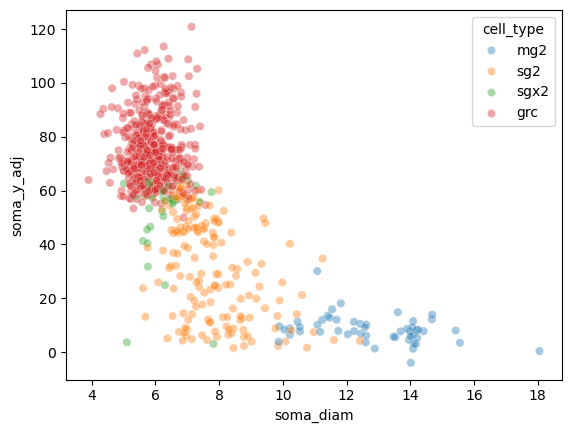

In [89]:
mask = df_soma_toplot['cell_type'].isin(['grc','sgx2','sg2','mg2'])
sns.scatterplot(data = df_soma_toplot[mask],x='soma_diam',y='soma_y_adj',hue='cell_type',alpha = 0.4)

# mask = df_soma['id'].isin(df_syn[df_syn['pre_type'].isin(['grc','sgx2','sg2','mg2'])]['pre'].unique())
# sns.scatterplot(data = df_soma[mask],x='soma_diam',y='soma_y_adj',color = 'gray')

# mask = df_soma['id'].isin(df_input[(df_input['annotation']=='full') & (df_input['completed']>0.85)].index.unique())
# sns.scatterplot(data = df_soma[mask],x='soma_diam',y='soma_y_adj',color='purple')#,{'marker':'X'})

<Axes: xlabel='soma_diam', ylabel='soma_y_adj'>

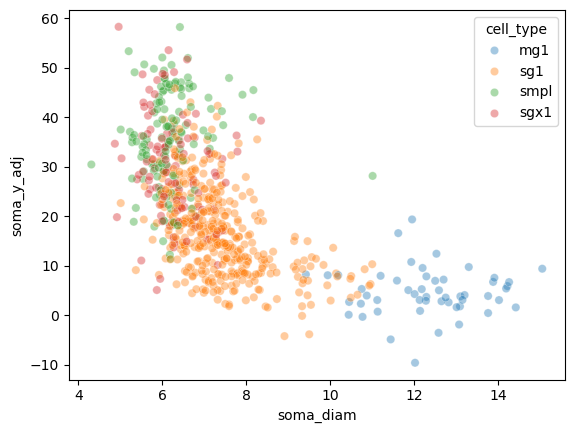

In [90]:
mask = df_soma_toplot['cell_type'].isin(['smpl','sgx1','sg1','mg1'])
sns.scatterplot(data = df_soma_toplot[mask],x='soma_diam',y='soma_y_adj',hue='cell_type',alpha = 0.4)

# mask = df_soma['id'].isin(df_syn[df_syn['pre_type'].isin(['grc','sgx2','sg2','mg2'])]['pre'].unique())
# sns.scatterplot(data = df_soma[mask],x='soma_diam',y='soma_y_adj',color = 'gray')

# mask = df_soma['id'].isin(df_input[(df_input['annotation']=='full') & (df_input['completed']>0.85)].index.unique())
# sns.scatterplot(data = df_soma[mask],x='soma_diam',y='soma_y_adj',color='purple')#,{'marker':'X'})

In [205]:
# list(df_syn[df_syn['pre_type'].isin(['grc','sgx2','sg2','mg2'])]['pre'].unique())

<Axes: xlabel='soma_diam', ylabel='soma_y_adj'>

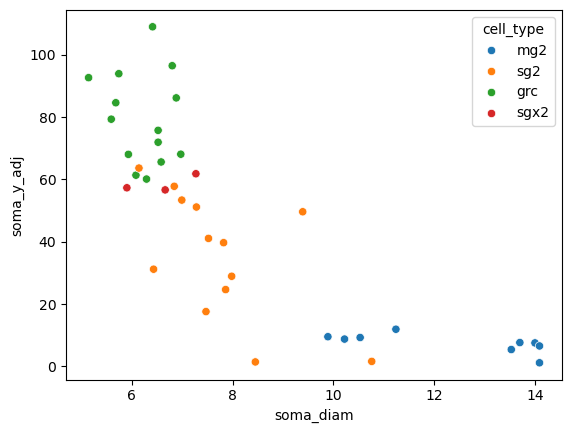

In [884]:
mask = df_soma['id'].isin(df_syn[df_syn['pre_type'].isin(['grc','sgx2','sg2','mg2'])]['pre'].unique())
sns.scatterplot(data = df_soma[mask],x='soma_diam',y='soma_y_adj',hue='cell_type')

In [969]:
# pd.merge(df_final.reset_index(),df_morph.reset_index(),on='id')
df_input.head()

,soma_diam,soma_x,soma_y,soma_z,soma_y_adj,aff,smpl,sgx1,sg1,mg1,...,di,sg,type,n_syn,done,todo,completed,cell_type,pc0,ad_count_y
id,,,,,,,,,,,,,,,,,,,,,
126649726,14.09,321.15,253.68,25.08,1.187783,0.0,20.0,3.0,67.0,1.0,...,90.0,70.0,mg2,161,161,0,1.000000,mg2,4.131090,4.131090
213605530,13.70,298.75,259.90,27.81,7.674273,1.0,12.0,3.0,61.0,21.0,...,76.0,64.0,mg2,141,141,0,1.000000,mg2,4.734261,4.734261
214581797,14.00,217.74,261.91,34.97,7.562301,5.0,40.0,5.0,201.0,42.0,...,246.0,206.0,mg2,582,581,1,0.998282,mg2,6.678509,6.678509
215492896,9.89,109.96,270.90,29.54,9.553840,24.0,26.0,28.0,49.0,0.0,...,103.0,77.0,mg2,225,204,21,0.906667,mg2,2.461180,2.461180
216129202,10.22,400.58,270.12,35.04,8.793995,0.0,5.0,0.0,22.0,22.0,...,27.0,22.0,mg2,86,64,22,0.744186,mg2,2.453538,2.453538


Text(0, 0.5, 'soma diameter')

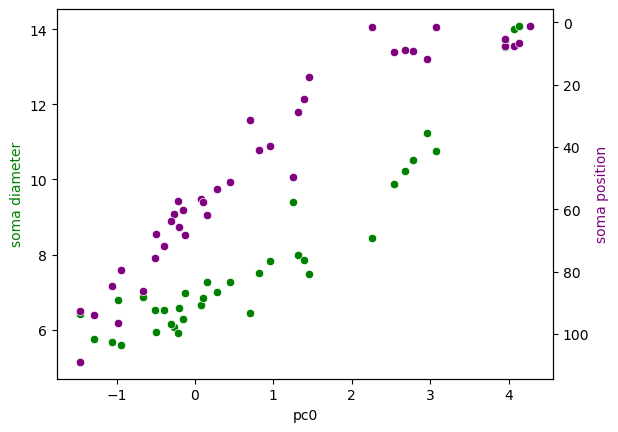

In [1052]:
fig, ax1 = plt.subplots()#figsize=(15,5)) # initializes figure and plots
ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.scatterplot(ax = ax1, data=df_input,y='soma_diam',x='pc0',color = 'green')

sns.scatterplot(ax = ax2, data=df_input,y='soma_y_adj',x='pc0',color = 'purple')
ax2.invert_yaxis()
ax2.set_ylabel('soma position',color='purple')

# sns.scatterplot(ax = ax2, data=df_input,y='ad_count_y',x='pc0',color = 'purple')
# ax2.set_ylabel('apical nodes',color='purple')


ax1.set_ylabel('soma diameter',color='green')


Text(0, 0.5, 'disinhibition input')

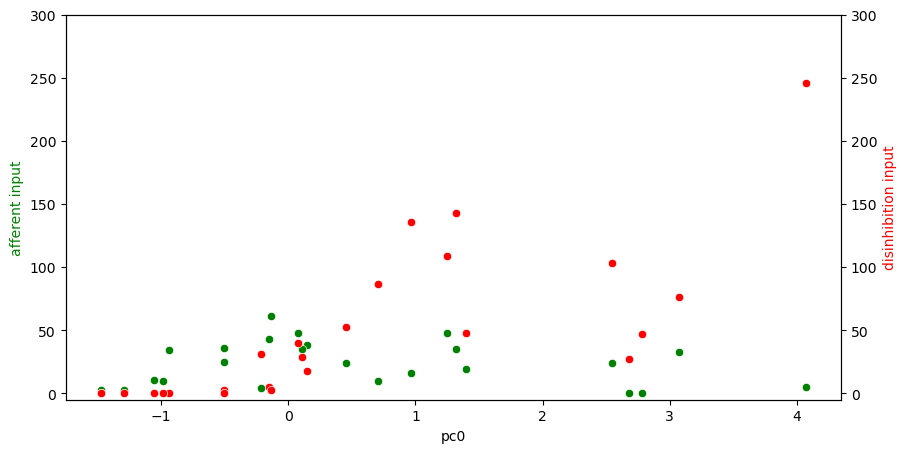

In [1053]:
mask = df_input['annotation']=='full'

fig, ax1 = plt.subplots(figsize=(10,5)) # initializes figure and plots
ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.scatterplot(data=df_input[mask],x='pc0',y='aff',ax = ax1, color='green')
sns.scatterplot(data=df_input[mask],x='pc0',y='di',ax = ax2,color='red')
# ax.set_ylim(0,2)
ax1.set_ylim(-5,300);ax1.set_ylabel('afferent input',color='green')
ax2.set_ylim(-5,300);ax2.set_ylabel('disinhibition input',color='red')

Text(0, 0.5, 'aff / disinhib')

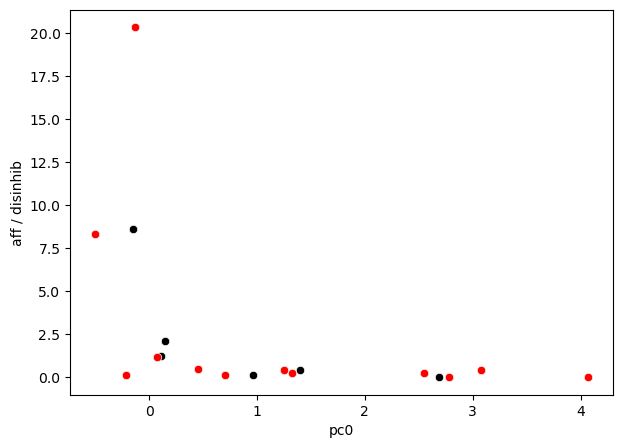

In [1054]:
fig, ax1 = plt.subplots(figsize=(7,5)) # initializes figure and plots
mask = df_input['annotation']=='full'
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['aff']/df_input[mask]['di'],color = 'black')

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['aff']/df_input[mask]['di'],color='red')

# mask = df_input['annotation']=='partial'
# sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['aff']/df_input[mask]['di'],color='gray')

# ax1.set_ylim(-1,5)
ax1.set_ylabel('aff / disinhib')

<Axes: xlabel='pc0', ylabel='aff'>

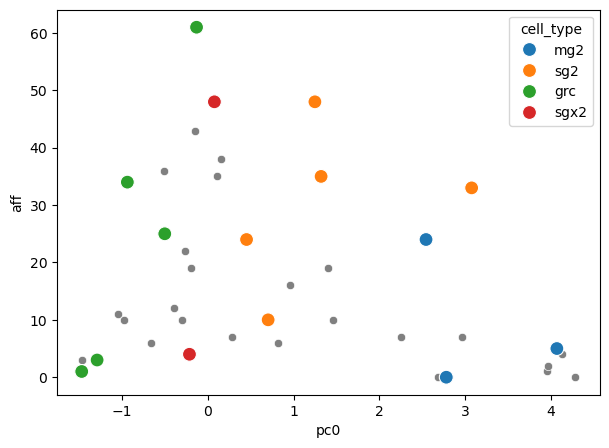

In [1055]:
fig, ax1 = plt.subplots(figsize=(7,5)) # initializes figure and plots

mask = df_input['annotation'].isin(['full','partial'])#df_input['annotation']=='full'
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['aff'],color='gray')

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['aff'],hue='cell_type',s=100)



# sns.scatterplot(data=df_input,x='soma_y_adj',y=df_input['aff']/df_input['di'],hue='cell_type')
# ax1.set_ylim(0,5)

<Axes: xlabel='pc0', ylabel='sg'>

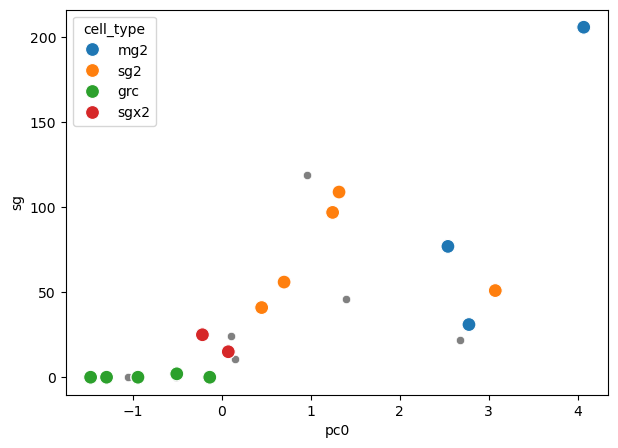

In [1056]:
fig, ax1 = plt.subplots(figsize=(7,5)) # initializes figure and plots

mask = df_input['annotation']=='full'
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['sg'],color='gray')

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['sg'],hue='cell_type',s=100)



# sns.scatterplot(data=df_input,x='soma_y_adj',y=df_input['aff']/df_input['di'],hue='cell_type')
# ax1.set_ylim(0,5)

<Axes: xlabel='pc0', ylabel='smpl'>

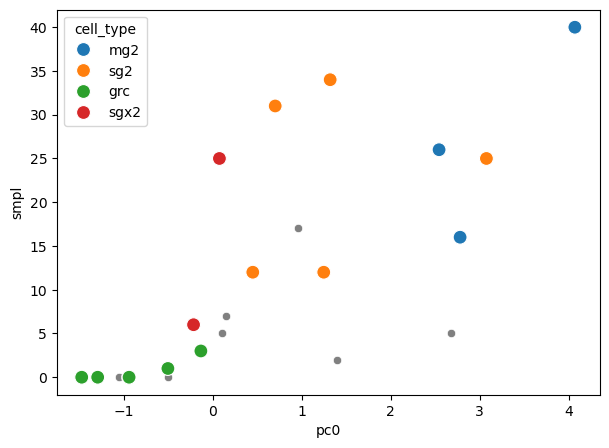

In [1057]:
fig, ax1 = plt.subplots(figsize=(7,5)) # initializes figure and plots

mask = df_input['annotation']=='full'
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['smpl'],color='gray')

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['smpl'],hue='cell_type',s=100)



# sns.scatterplot(data=df_input,x='soma_y_adj',y=df_input['aff']/df_input['di'],hue='cell_type')
# ax1.set_ylim(0,5)

<Axes: xlabel='pc0', ylabel='di'>

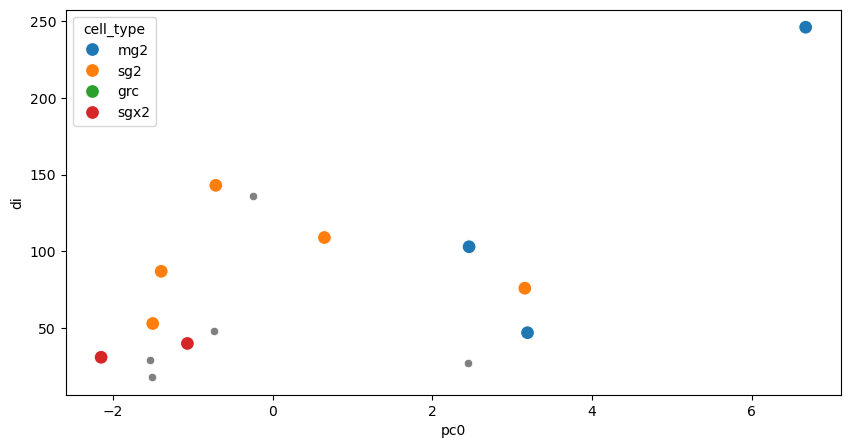

In [932]:
fig, ax1 = plt.subplots(figsize=(10,5)) # initializes figure and plots
mask = df_input['annotation']=='full'
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['di'],color='gray')

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='pc0',y=df_input[mask]['di'],hue='cell_type',s=100)

# sns.scatterplot(data=df_input,x='soma_y_adj',y=df_input['aff']/df_input['di'],hue='cell_type')
# ax1.set_ylim(0,5)

### regardless of morphology

, across these type2 cells, how are aff and disinhibition input related

<Axes: xlabel='aff', ylabel='di'>

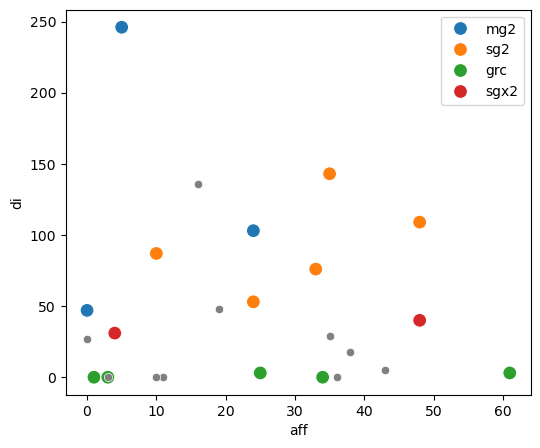

In [1031]:
fig, ax1 = plt.subplots(figsize=(6,5)) # initializes figure and plots

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='aff',y='di',hue='cell_type',s=100)

mask = (df_input['annotation']=='full') & (df_input['completed']<0.85)
sns.scatterplot(data=df_input[mask],x='aff',y='di',color='gray')
# ax1.set_ylim(0,5)
# ax1.set_ylabel('aff / disinhib')

Text(0, 0.5, 'smpl')

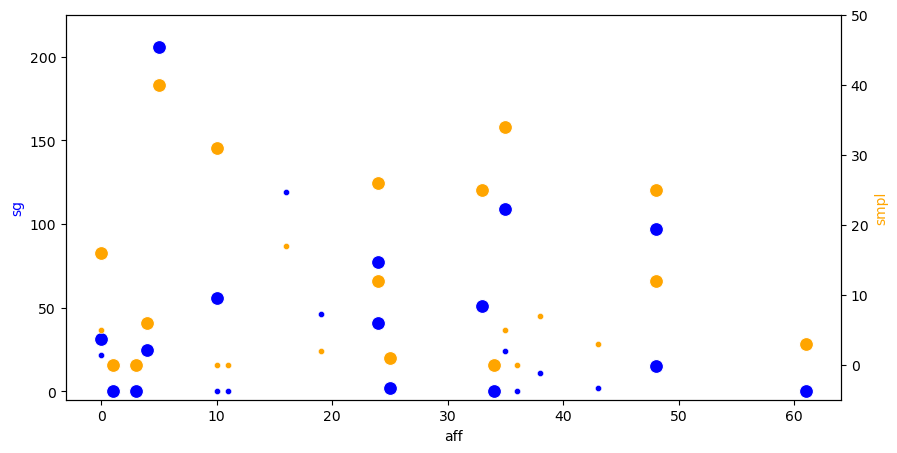

In [1063]:
# fig, ax1 = plt.subplots(figsize=(8,5)) # initializes figure and plots

fig, ax1 = plt.subplots(figsize=(10,5)) # initializes figure and plots
ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

mask = (df_input['annotation']=='full') #& (df_input['completed']>0.85)
# sns.scatterplot(data=df_input[mask],x='aff',y='sg1',color='purple',s=100)
sns.scatterplot(ax = ax1, data=df_input[mask],x='aff',y='sg',color='blue',s=20)
sns.scatterplot(ax = ax2, data=df_input[mask],x='aff',y='smpl',color='orange',s=20)

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
# sns.scatterplot(data=df_input[mask],x='aff',y='sg1',color='purple',s=100)
sns.scatterplot(ax = ax1, data=df_input[mask],x='aff',y='sg',color='blue',s=100)
sns.scatterplot(ax = ax2, data=df_input[mask],x='aff',y='smpl',color='orange',s=100)

ax1.set_ylim(-5,225); ax1.set_ylabel('sg',color='blue')
ax2.set_ylim(-5,50); ax2.set_ylabel('smpl',color='orange')

# # ax1.set_ylim(0,5)

# ax1.set_ylabel('sg (blue); smpl (orange)')

# fig, ax1 = plt.subplots(figsize=(10,5)) # initializes figure and plots
# ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

# sns.scatterplot(data=df_input[mask],x='pc0',y='aff',ax = ax1, color='green')
# sns.scatterplot(data=df_input[mask],x='pc0',y='di',ax = ax2,color='red')
# # ax.set_ylim(0,2)
# ax1.set_ylim(-5,300);ax1.set_ylabel('afferent input',color='green')
# ax2.set_ylim(-5,300);ax2.set_ylabel('disinhibition input',color='red')

<Axes: xlabel='smpl', ylabel='sg'>

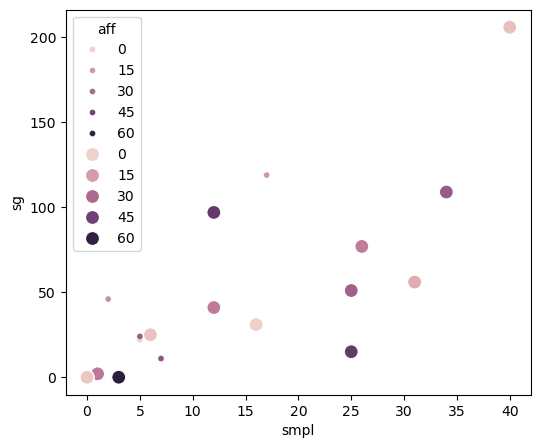

In [1036]:
fig, ax1 = plt.subplots(figsize=(6,5)) # initializes figure and plots

mask = (df_input['annotation']=='full') #& (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='smpl',y='sg',color='blue',hue='aff',s=20)

mask = (df_input['annotation']=='full') & (df_input['completed']>0.85)
sns.scatterplot(data=df_input[mask],x='smpl',y='sg',color='blue',hue='aff',s=100)

In [114]:
df_syn[df_syn['pre_type'].isin(['sgx2'])]['pre'].unique()

array([394470350])

In [113]:
df_syn[df_syn['pre_type'].isin(['sg2'])]['pre'].unique()

array([218095913, 306461085, 385434515, 389891998, 393433572, 394423863,
       395507584, 473491444, 477962738,  50786130, 647514445])

In [247]:
df_syn[df_syn['pre_type'].isin(['grc'])]['pre'].unique()

array([222597526, 223881844, 226019332, 227254070, 228321391, 228366816,
       313068329, 395461156, 400210172, 403522169, 481412554, 482680782,
       483610898, 483689146])

### synapse annotations plotted in space

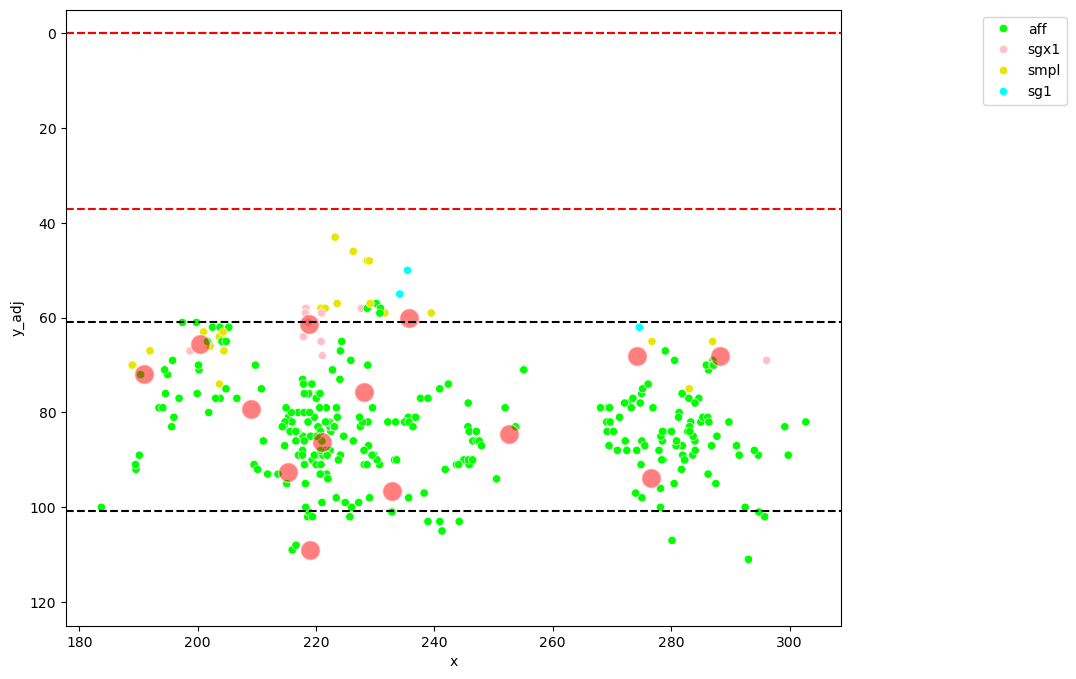

In [1071]:
hfig,ax = plt.subplots(1,figsize=(10,8))
synmask = (df_syn['pre_type'].isin(['grc'])) & (df_syn['post_type'].isin(['aff','smpl','sgx1','sg1','mg1']))
sns.scatterplot(data=df_syn[synmask],x='x',y='y_adj',hue='post_type',palette=cell_colors,alpha = 1) #['sg1','sg2','mg1','mg2','lg','lf']
sns.scatterplot(data=df_soma[df_soma['id'].isin(df_syn[synmask]['pre'])],x='soma_x',y='soma_y_adj',color='red',s=200,alpha=0.5) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
# ax.set_xlim(50,400)
ax.invert_yaxis()
plt.show()

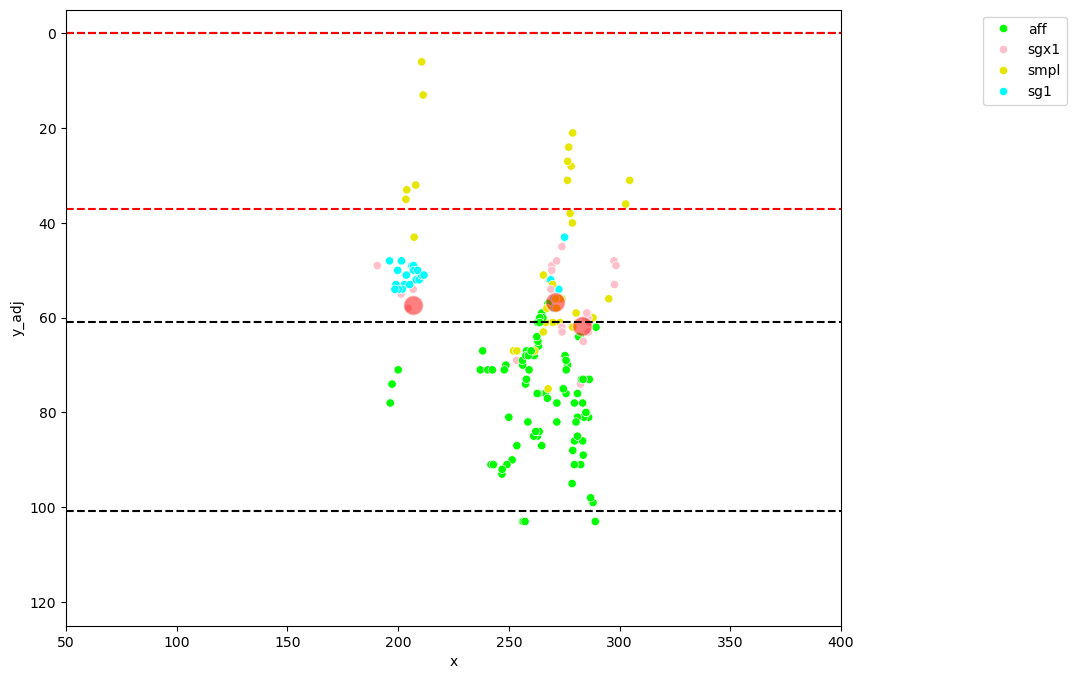

In [1072]:
hfig,ax = plt.subplots(1,figsize=(10,8))
synmask = (df_syn['pre_type'].isin(['sgx2'])) & (df_syn['post_type'].isin(['aff','smpl','sgx1','sg1','mg1']))
sns.scatterplot(data=df_syn[synmask],x='x',y='y_adj',hue='post_type',palette=cell_colors,alpha = 1) #['sg1','sg2','mg1','mg2','lg','lf']
sns.scatterplot(data=df_soma[df_soma['id'].isin(df_syn[synmask]['pre'])],x='soma_x',y='soma_y_adj',color='red',s=200,alpha=0.5) #['sg1','sg2','mg1','mg2','lg','lf']

for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
ax.set_xlim(50,400)
ax.invert_yaxis()
plt.show()

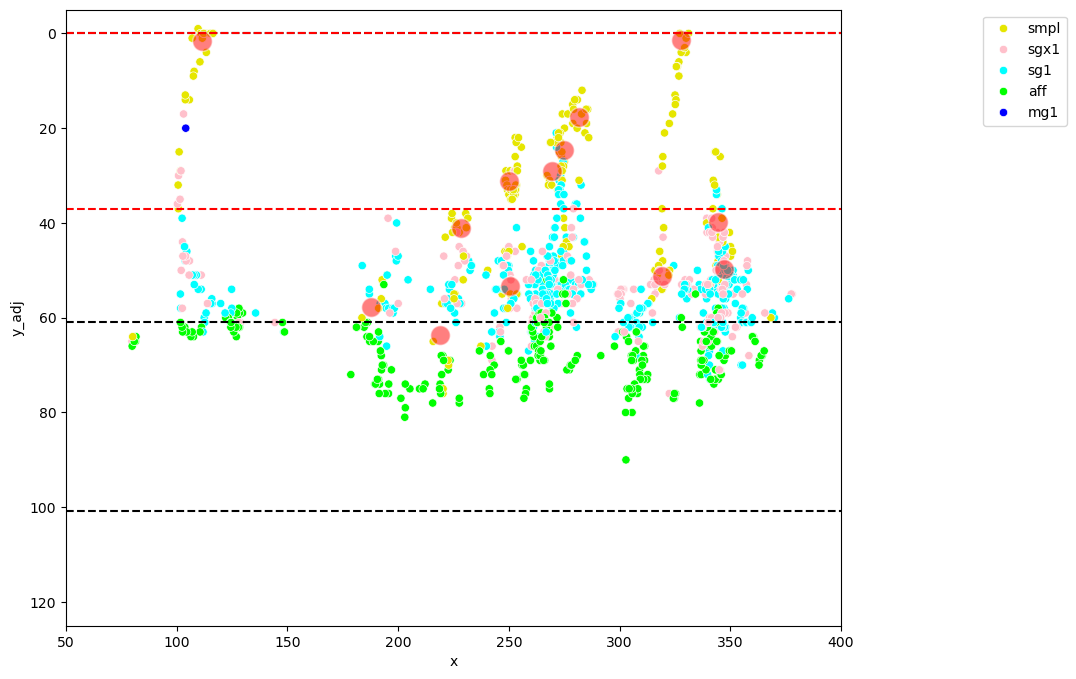

In [1074]:
hfig,ax = plt.subplots(1,figsize=(10,8))
synmask = (df_syn['pre_type'].isin(['sg2'])) & (df_syn['post_type'].isin(['aff','smpl','sgx1','sg1','mg1']))
sns.scatterplot(data=df_syn[synmask],x='x',y='y_adj',hue='post_type',palette=cell_colors,alpha = 1) #['sg1','sg2','mg1','mg2','lg','lf']
sns.scatterplot(data=df_soma[df_soma['id'].isin(df_syn[synmask]['pre'])],x='soma_x',y='soma_y_adj',color='red',s=200,alpha=0.5) #['sg1','sg2','mg1','mg2','lg','lf']

for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
ax.set_xlim(50,400)
ax.invert_yaxis()
plt.show()

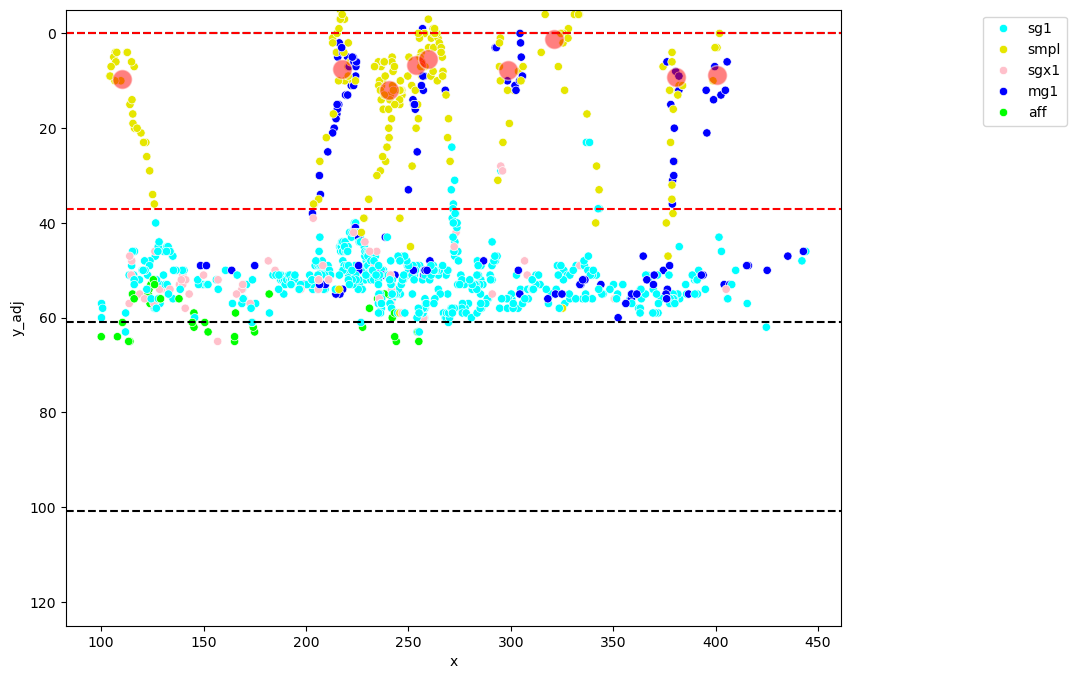

In [1075]:
hfig,ax = plt.subplots(1,figsize=(10,8))
synmask = (df_syn['pre_type'].isin(['mg2'])) & (df_syn['post_type'].isin(['aff','smpl','sgx1','sg1','mg1']))
sns.scatterplot(data=df_syn[synmask],x='x',y='y_adj',hue='post_type',palette=cell_colors,alpha = 1) #['sg1','sg2','mg1','mg2','lg','lf']
sns.scatterplot(data=df_soma[df_soma['id'].isin(df_syn[synmask]['pre'])],x='soma_x',y='soma_y_adj',color='red',s=200,alpha=0.5) #['sg1','sg2','mg1','mg2','lg','lf']

for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
# ax.set_xlim(50,400)
ax.invert_yaxis()
plt.show()

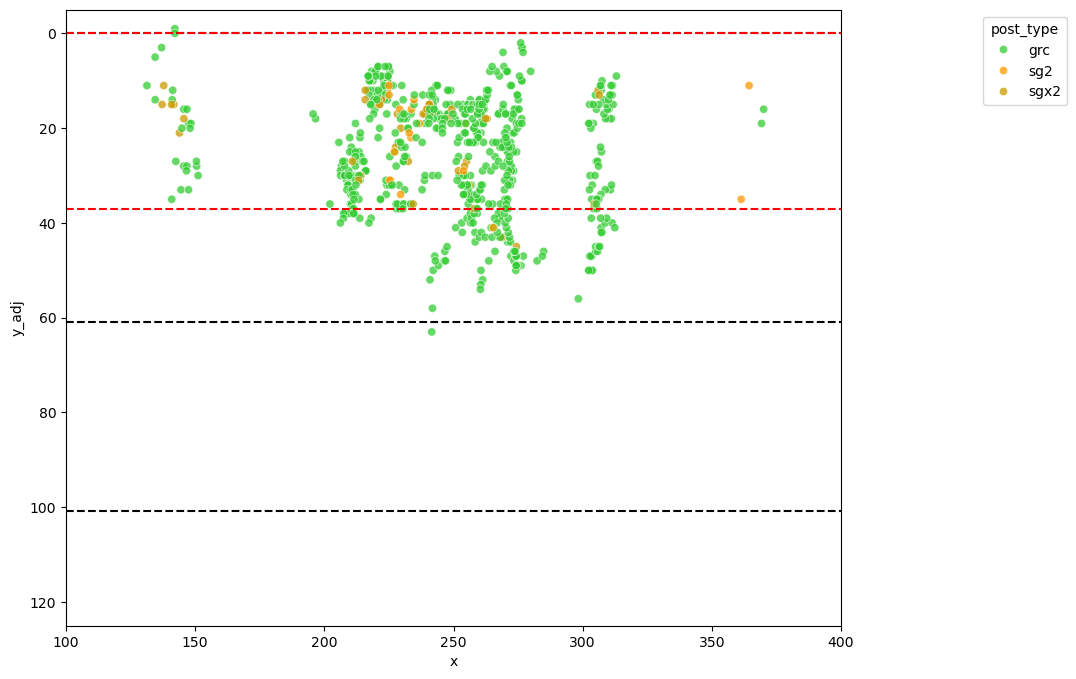

In [131]:
hfig,ax = plt.subplots(1,figsize=(10,8))
mask = df_syn['pre_type'].isin(['sg1']) & df_syn['post_type'].isin(['mg2','sg2','sgx2','grc'])
sns.scatterplot(data=df_syn[mask],x='x',y='y_adj',hue='post_type',palette=cell_colors,alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
ax.set_xlim(100,400)
ax.invert_yaxis()
plt.show()

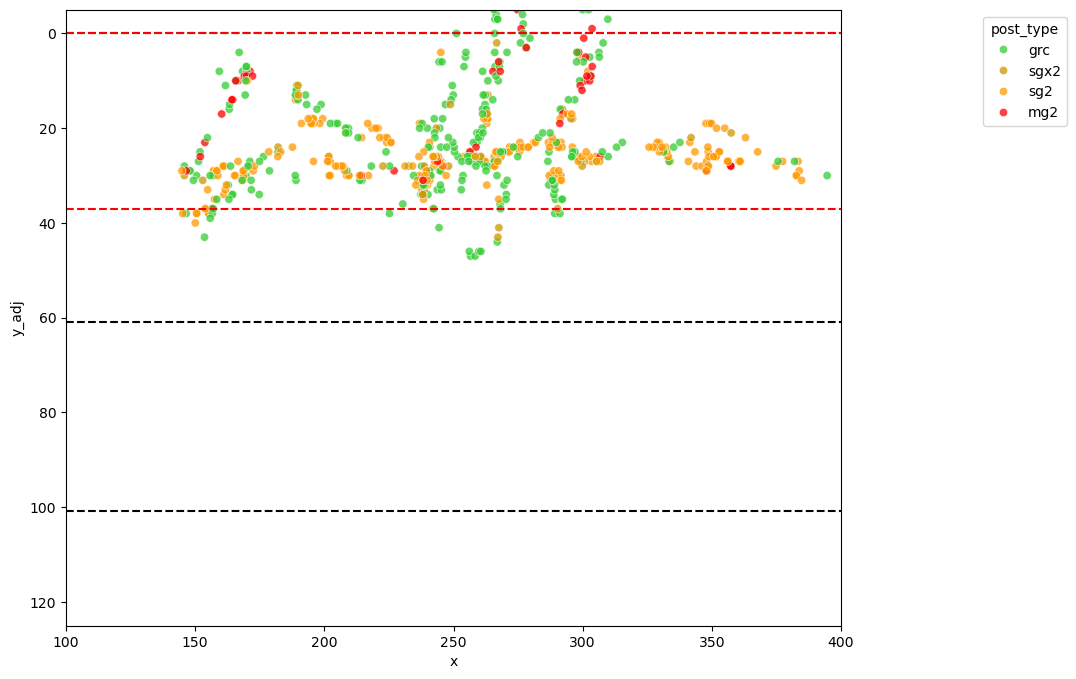

In [130]:
hfig,ax = plt.subplots(1,figsize=(10,8))
mask = df_syn['pre_type'].isin(['mg1']) & df_syn['post_type'].isin(['mg2','sg2','sgx2','grc'])#'smpl','aff'])
sns.scatterplot(data=df_syn[mask],x='x',y='y_adj',hue='post_type',palette=cell_colors,alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
ax.set_xlim(100,400)
ax.invert_yaxis()
plt.show()

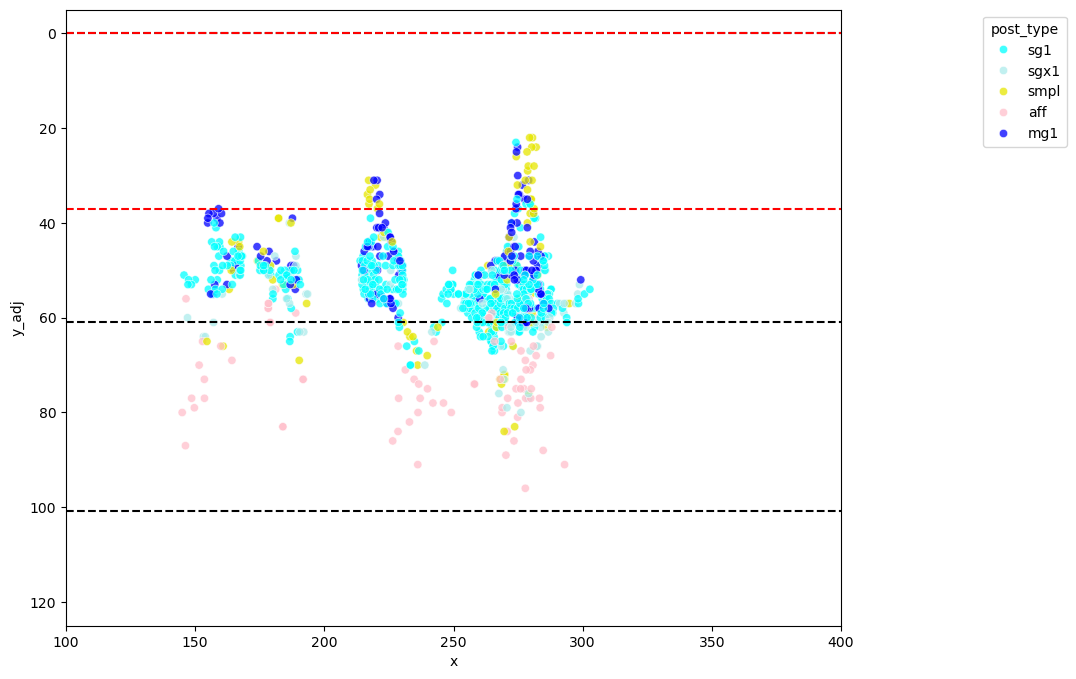

In [113]:
hfig,ax = plt.subplots(1,figsize=(10,8))
mask = df_syn['pre_type'].isin(['lf']) & df_syn['post_type'].isin(['mg1','sg1','sgx1','smpl','aff'])
sns.scatterplot(data=df_syn[mask],x='x',y='y_adj',hue='post_type',palette=cell_colors,alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
ax.set_xlim(100,400)
ax.invert_yaxis()
plt.show()

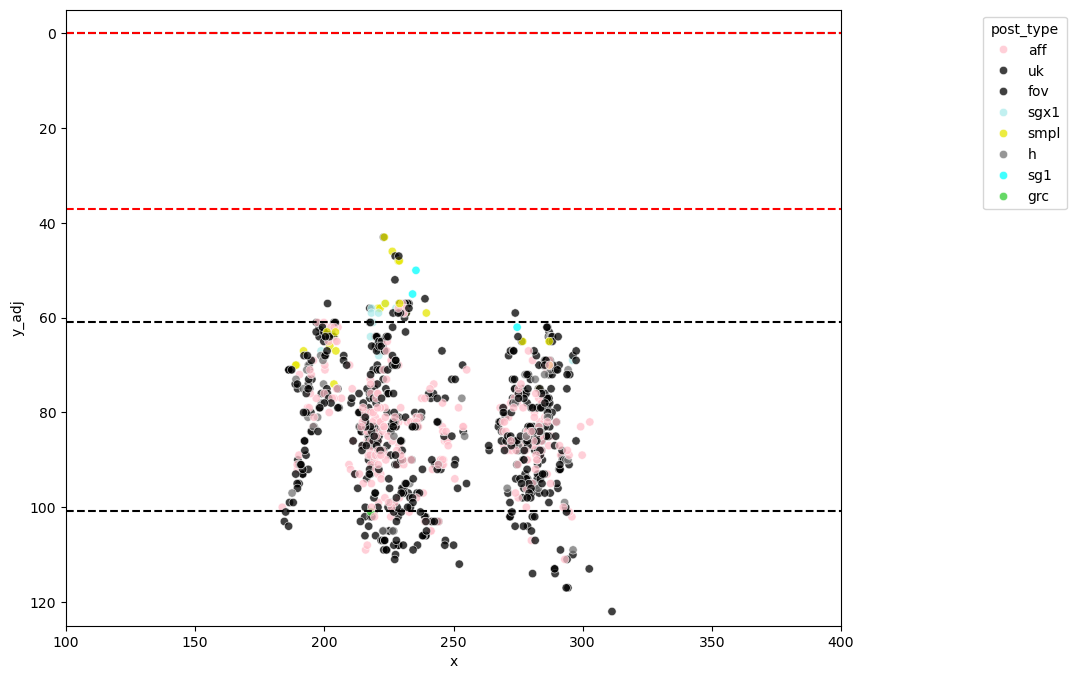

In [114]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.scatterplot(data=df_syn[df_syn['pre_type'].isin(['grc'])],x='x',y='y_adj',hue='post_type',palette=cell_colors,alpha = 0.75) #['sg1','sg2','mg1','mg2','lg','lf']
for y_ in [(22000-15700)*16, (19500-15700)*16, (15700-15700)*16]: #(17650-15700)*16, 
    ax.axhline(y=y_/1000,color = 'black',linestyle='--')
for y_ in [0,37]:
    ax.axhline(y=y_,color = 'red',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(-5,125)
ax.set_xlim(100,400)
ax.invert_yaxis()
plt.show()

## morphology_cat h5

In [3]:
'''old way of saving and using morphology info as h5'''

h5savepath = Path(dirpath).parent / 'meta_analysis/morphology_cat/h5_files_old'

# '''from when was using h5 instead of dataframe to store info'''
# h5filename_list = ['df_nodes_axon_type1.h5','df_nodes_axon_type2.h5']#,'df_nodes_axon_grc.h5']
# suff_ = 'ax_'
# df_ax_prepped = pd.DataFrame()
# for h5filename in h5filename_list:
#   with pd.HDFStore(h5savepath / h5filename) as df_store:
#     for i in df_store.keys():
#       focal_cell_id = i[1:]
#       df_ = df_store[i]
#       df_.reset_index(inplace=True)
#       df_.rename(columns={'index': 'statistic'}, inplace=True)
#       # Step 2: Melt df_bd to combine each column with the 'statistic' column
#       df_melted = pd.melt(df_, id_vars=['statistic'], var_name='dimension', value_name='value')
#       # Step 3: Combine 'statistic' and 'dimension' columns to create a new column
#       df_melted['parameter'] = suff_ + df_melted['statistic'] + '_' + df_melted['dimension']
#       df_melted['id'] = int(focal_cell_id)
#       df_reshaped = df_melted.pivot(index='id', columns='parameter', values='value')
#       df_ax_prepped = pd.concat([df_ax_prepped, df_reshaped])

# h5filename_list = ['df_nodes_bd_type1.h5','df_nodes_bd_type2.h5']#,'df_nodes_bd_grc.h5']
# suff_ = 'bd_'
# df_bd_prepped = pd.DataFrame()
# for h5filename in h5filename_list:
#   with pd.HDFStore(h5savepath / h5filename) as df_store:
#     for i in df_store.keys():
#       focal_cell_id = i[1:]
#       df_ = df_store[i]
#       df_.reset_index(inplace=True)
#       df_.rename(columns={'index': 'statistic'}, inplace=True)
#       # Step 2: Melt df_bd to combine each column with the 'statistic' column
#       df_melted = pd.melt(df_, id_vars=['statistic'], var_name='dimension', value_name='value')
#       # Step 3: Combine 'statistic' and 'dimension' columns to create a new column
#       df_melted['parameter'] = suff_ + df_melted['statistic'] + '_' + df_melted['dimension']
#       df_melted['id'] = int(focal_cell_id)
#       df_reshaped = df_melted.pivot(index='id', columns='parameter', values='value')
#       df_bd_prepped = pd.concat([df_bd_prepped, df_reshaped])

# h5filename_list = ['df_nodes_ad_type1.h5','df_nodes_ad_type2.h5'] 
# suff_ = 'ad_'
# df_ad_prepped = pd.DataFrame()
# for h5filename in h5filename_list:
#   with pd.HDFStore(h5savepath / h5filename) as df_store:
#     for i in df_store.keys():
#       focal_cell_id = i[1:]
#       df_ = df_store[i]
#       df_.reset_index(inplace=True)
#       df_.rename(columns={'index': 'statistic'}, inplace=True)
#       # Step 2: Melt df_bd to combine each column with the 'statistic' column
#       df_melted = pd.melt(df_, id_vars=['statistic'], var_name='dimension', value_name='value')
#       # Step 3: Combine 'statistic' and 'dimension' columns to create a new column
#       df_melted['parameter'] = suff_ + df_melted['statistic'] + '_' + df_melted['dimension']
#       df_melted['id'] = int(focal_cell_id)
#       df_reshaped = df_melted.pivot(index='id', columns='parameter', values='value')
#       df_ad_prepped = pd.concat([df_ad_prepped, df_reshaped])

# df_ax = df_ax_prepped.reset_index()
# df_ax.set_index('id',inplace=True)

# df_bd = df_bd_prepped.reset_index()
# df_bd.set_index('id',inplace=True)

# df_ad = df_ad_prepped.reset_index()
# df_ad.set_index('id',inplace=True)

NameError: name 'Path' is not defined